# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (lrti), upper respiratory tract infection (lrti), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [52]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import calibration_curve
from datetime import date
from operator import attrgetter
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [53]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [54]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [55]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [56]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

In [57]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [ ]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'hx_hosp', 'CCI', 'died_date', 'deregistered_date',  #'meds_nonabs', 
                   'gp_count_'+str(i), 'antibacterial_brit_'+str(i), 
                   'gp_cons_lrti_'+str(i), #'gp_cons_lrti_ab_'+str(i),
                   'lrti_date_'+str(i), 'lrti_ab_date_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    # #drop rows with no gp_cons_lrti_i records
    # datum = datum.dropna(subset=['gp_cons_lrti_'+str(i)])
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date',
                           'gp_count_'+str(i): 'gp_count', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'gp_cons_lrti_'+str(i): 'gp_cons_lrti', #'gp_cons_lrti_ab_'+str(i): 'gp_cons_lrti_ab',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', #'prevl_lrti_date_'+str(i): 'prevl_lrti_date',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

## 1- Data Preparation

In [58]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')
# data_bmi = pd.read_csv(f'../output/hospitalisation_data/input_bmi.csv.gz')

data.shape

(200000, 164)

In [59]:
# save model outputs
a = open("../output/hospitalisation_prediction_lrti/data_lrti_record_cph_lrti.txt", "w")
a.write("")
a.writelines(['data_lrti_1 #with a record, #with no record: %.0f' % (data['lrti_date_1'].notna().sum()), ', %.0f' % (data['lrti_date_1'].isna().sum()),
              '\ndata_lrti_2 #with a record, #with no record: %.0f' % (data['lrti_date_2'].notna().sum()), ', %.0f' % (data['lrti_date_2'].isna().sum()),
              '\ndata_lrti_3 #with a record, #with no record: %.0f' % (data['lrti_date_3'].notna().sum()), ', %.0f' % (data['lrti_date_3'].isna().sum()),
              '\ndata_lrti_4 #with a record, #with no record: %.0f' % (data['lrti_date_4'].notna().sum()), ', %.0f' % (data['lrti_date_4'].isna().sum()),
              '\ndata_lrti_5 #with a record, #with no record: %.0f' % (data['lrti_date_5'].notna().sum()), ', %.0f' % (data['lrti_date_5'].isna().sum()),
              '\ndata_lrti_6 #with a record, #with no record: %.0f' % (data['lrti_date_6'].notna().sum()), ', %.0f' % (data['lrti_date_6'].isna().sum()),
              '\ndata_lrti_7 #with a record, #with no record: %.0f' % (data['lrti_date_7'].notna().sum()), ', %.0f' % (data['lrti_date_7'].isna().sum()),
              '\ndata_lrti_8 #with a record, #with no record: %.0f' % (data['lrti_date_8'].notna().sum()), ', %.0f' % (data['lrti_date_8'].isna().sum()),
              '\ndata_lrti_9 #with a record, #with no record: %.0f' % (data['lrti_date_9'].notna().sum()), ', %.0f' % (data['lrti_date_9'].isna().sum()),
              '\ndata_lrti_10 #with a record, #with no record: %.0f' % (data['lrti_date_10'].notna().sum()), ', %.0f' % (data['lrti_date_10'].isna().sum()),
              '\ndata_lrti_11 #with a record, #with no record: %.0f' % (data['lrti_date_11'].notna().sum()), ', %.0f' % (data['lrti_date_11'].isna().sum()),
              '\ndata_lrti_12 #with a record, #with no record: %.0f' % (data['lrti_date_12'].notna().sum()), ', %.0f' % (data['lrti_date_12'].isna().sum()),
              '\ndata_lrti_13 #with a record, #with no record: %.0f' % (data['lrti_date_13'].notna().sum()), ', %.0f' % (data['lrti_date_13'].isna().sum()),
              '\ndata_lrti_14 #with a record, #with no record: %.0f' % (data['lrti_date_14'].notna().sum()), ', %.0f' % (data['lrti_date_14'].isna().sum()),
              '\ndata_lrti_15 #with a record, #with no record: %.0f' % (data['lrti_date_15'].notna().sum()), ', %.0f' % (data['lrti_date_15'].isna().sum()),
              '\ndata_lrti_16 #with a record, #with no record: %.0f' % (data['lrti_date_16'].notna().sum()), ', %.0f' % (data['lrti_date_16'].isna().sum()),
              '\ndata_lrti_17 #with a record, #with no record: %.0f' % (data['lrti_date_17'].notna().sum()), ', %.0f' % (data['lrti_date_17'].isna().sum()),
              '\ndata_lrti_18 #with a record, #with no record: %.0f' % (data['lrti_date_18'].notna().sum()), ', %.0f' % (data['lrti_date_18'].isna().sum()),
              ])

In [60]:
# # save model outputs
# a = open("../output/hospitalisation_prediction_lrti/data_gp_counts_cph_lrti.txt", "w")
# a.write("")
# a.writelines(['data_lrti_1 #with gp cons, #with no gp cons: %.0f' % (data['gp_cons_lrti_1'].notna().sum()), ', %.0f' % (data['gp_cons_lrti_1'].isna().sum()),
#               '\ndata_lrti_2 #with gp cons, #with no gp cons: %.0f' % (data['gp_cons_lrti_2'].notna().sum()), ', %.0f' % (data['gp_cons_lrti_2'].isna().sum()),
#               '\ndata_lrti_3 #with gp cons, #with no gp cons: %.0f' % (data['gp_cons_lrti_3'].notna().sum()), ', %.0f' % (data['gp_cons_lrti_3'].isna().sum()),
#               '\ndata_lrti_4 #with gp cons, #with no gp cons: %.0f' % (data['gp_cons_lrti_4'].notna().sum()), ', %.0f' % (data['gp_cons_lrti_4'].isna().sum()),
#               ])

In [61]:
data.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,admitted_date,lrti_date_1,lrti_date_2,...,sgss_gp_cov_lrti_date_8,sgss_gp_cov_lrti_date_9,sgss_gp_cov_lrti_date_10,sgss_gp_cov_lrti_date_11,sgss_gp_cov_lrti_date_12,lrti_ab_count_1,lrti_ab_count_2,lrti_ab_count_3,lrti_ab_count_4,patient_id
count,10000,20000,150000,20000,20000,20000,20000,60000,20000,20000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05
unique,1337,753,44,44,44,13,13,1338,1338,1338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2020-11-14,2022-08-30,2019-05,2019-08,2019-08,2018-10,2018-03,2021-05-13,2021-08-01,2020-07-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,18,157,3572,503,502,1727,1718,68,29,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.899895,0.899345,0.899235,0.900885,9.999958e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,1.858892,1.858454,1.857576,1.860728,5.760086e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.017292e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.988820e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.498099e+06


### 1-2- Additional variables
#### 1-2-1- Calculating Charlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [62]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')
# col18 = data.columns.get_loc('age')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37127
1.0     36923
2.0     32977
3.0     24753
4.0     15177
6.0     12308
7.0      9974
5.0      8266
8.0      8012
9.0      5686
10.0     3398
11.0     1874
12.0     1355
13.0      816
14.0      578
15.0      382
16.0      214
17.0      102
18.0       50
19.0       16
20.0        8
21.0        4
Name: CCI, dtype: int64

#### 1-2-2- Calculating all meds except abs

In [63]:
# #generate meds_noabs in the one month before
# data['meds_nonabs'] = data['all_meds'] - data['antibacterial_brit']

# # assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
# data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

# data['meds_nonabs'].value_counts()
# # data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

## 2- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- Gathering data

In [67]:
#read 12 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12])
data_lrti.reset_index(inplace=True, drop=True)
data_lrti.shape

(216087, 21)

### 2-2- Add season, event, and duration variables
#### Season

In [68]:
# convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
data_lrti['gp_cons_lrti'] = data_lrti['gp_cons_lrti'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] #gp_cons_lrti
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')
data_lrti.shape

(216087, 22)

In [69]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get 2 months before today's date in year and month 
last_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_month_date_y_m = last_month_date_y_m.strftime('%Y-%m')
#drop any record of data with 1 month before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

data_lrti['season'].value_counts()

spring    59318
winter    53701
summer    49386
autumn    43635
Name: season, dtype: int64

In [70]:
data_lrti['date'].min()

'2019-01'

In [71]:
# data_lrti = data_lrti[data_lrti['date'] <= '2019-12']
# data_lrti = data_lrti[(data_lrti['date'] >= '2020-03') & (data_lrti['date']<= '2021-03')]
# data_lrti = data_lrti[data_lrti['date'] >= '2021-04']
data_lrti.shape

(206040, 24)

In [72]:
data_lrti['date'].max()

'2022-07'

#### event and duration variables

In [73]:
#scenario 1
#not hosped (nothing happened)
#data_lrti = data_lrti[data_lrti['admitted_lrti_date'].notnull()]
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0
data_lrti['event_lrti_admitted'].value_counts()

0.0    144376
Name: event_lrti_admitted, dtype: int64

In [74]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['gp_cons_lrti']).dt.days
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1
# data_lrti['event_lrti_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]
data_lrti['delta_lrti_admitted'].value_counts()

135.0     11
241.0     10
101.0      9
174.0      9
268.0      9
          ..
777.0      1
854.0      1
859.0      1
1223.0     1
1022.0     1
Name: delta_lrti_admitted, Length: 1059, dtype: int64

In [75]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_lrti.loc[data_lrti['delta_admitted_died'] >= 0, 'event_lrti_admitted'] = 0
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0
# data_lrti['event_lrti_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_lrti.loc[data_lrti['delta_admitted_deregistered'] >= 0, 'event_lrti_admitted'] = 0
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0
# data_lrti['event_lrti_admitted'].value_counts()

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_lrti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

196399

In [76]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)
data_lrti['event_lrti_admitted'].value_counts()

0.0    202827
1.0       128
Name: event_lrti_admitted, dtype: int64

In [77]:
#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30
data_lrti['duration_lrti_admitted'].value_counts()

30.0    202651
6.0         16
17.0        16
24.0        14
28.0        13
27.0        13
8.0         13
5.0         13
10.0        12
4.0         12
29.0        12
11.0        11
0.0         11
2.0         11
14.0        10
19.0        10
15.0        10
13.0         9
26.0         9
25.0         9
18.0         9
23.0         8
7.0          8
1.0          8
22.0         8
9.0          8
20.0         7
21.0         7
3.0          6
12.0         6
16.0         5
Name: duration_lrti_admitted, dtype: int64

In [78]:
# give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1
data_lrti['event_lrti_admitted'].value_counts()

0.0    202645
1.0       310
Name: event_lrti_admitted, dtype: int64

In [79]:
#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

In [80]:
# data_lrti[data_lrti['duration_lrti_admitted']==0][['delta_lrti_admitted', 'lrti_date', 'gp_cons_lrti', 'admitted_lrti_date', 'delta_lrti_admitted', 'delta_admitted_died_deregistered', 'event_lrti_admitted', 'duration_lrti_admitted']]
# data_lrti.loc[151:200, ['event_lrti_admitted', 'duration_lrti_admitted']]
# data_lrti.loc[201:250, ['event_lrti_admitted', 'duration_lrti_admitted']].sort_values(by=['duration_lrti_admitted'])
data_lrti[['event_lrti_admitted', 'duration_lrti_admitted']].sort_values(by=['duration_lrti_admitted'])

,event_lrti_admitted,duration_lrti_admitted
187583,1.0,1.0
34778,1.0,1.0
88891,1.0,1.0
204409,1.0,1.0
181162,1.0,1.0
...,...,...
72132,0.0,30.0
72133,0.0,30.0
72134,0.0,30.0
72136,0.0,30.0


In [81]:
# save data shape
a = open("../output/hospitalisation_prediction_lrti/data_shape_cph_lrti_after_season.txt", "w")
a.write("")
a.writelines(['data_lrti #observations, #events: %.0f' % (data_lrti.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti.event_lrti_admitted.value_counts()[1]),
            #   '\ndata_lrti_abs_incdt #observations, #events: %.0f' % (data_lrti_abs_incdt.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_abs_incdt.event_lrti_admitted.value_counts()[1]),
            #   '\ndata_lrti_no_abs_prevl #observations, #events: %.0f' % (data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()[1]),
            #   '\ndata_lrti_abs_prevl #observations, #events: %.0f' % (data_lrti_abs_prevl.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_abs_prevl.event_lrti_admitted.value_counts()[1])
              ])

### 2-4- Dealing with uninteresting and missing values

In [82]:
# prep before plot
data_lrti['age'][data_lrti['age'] < 0] = np.nan
# drop anybody with age less than 18
data_lrti = data_lrti[~(data_lrti['age'] < 18)]  
print(f'Min age: {data_lrti.age.min()}')

## remove died cases
#data_lrti.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
# replace 0s with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})

# remove cases with negative gp_count
data_lrti['gp_count'][data_lrti['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [83]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})

In [84]:
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_lrti['region_imp'] = data_lrti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_lrti.region.isnull().sum()}')
    data_lrti = data_lrti[data_lrti['region'].notna()]

print(f'Cound of missing values in variable region: {data_lrti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_lrti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      32347
Yorkshire and The Humber    16250
East Midlands               16111
South East                  16076
South West                  16040
North West                  15988
East                        15843
West Midlands               15802
North East                  15692
Name: region, dtype: int64


In [85]:
if ('gp_count' in data_lrti.columns) and (data_lrti['gp_count'].isnull().sum() > 0):
    print(f'Cound of missing values in variable gp_count before changing NAN to zeros: {data_lrti.gp_count.isnull().sum()}')
    print(f'Mean of gp_count values before changing NAN to zeros: {data_lrti.gp_count.mean():.3f}')
    data_lrti['gp_count'] = data_lrti['gp_count'].fillna(0)
    # data_lrti['gp_count'] = data_lrti['gp_count'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable gp_count after changing NANs to zeros: {data_lrti.gp_count.isnull().sum()}')
print(f'Mean of gp_count values after changing NANs to zeros: {data_lrti.gp_count.mean():.3f}')

Cound of missing values in variable gp_count before changing NAN to zeros: 943
Mean of gp_count values before changing NAN to zeros: 3.341

Cound of missing values in variable gp_count after changing NANs to zeros: 0
Mean of gp_count values after changing NANs to zeros: 3.321


In [86]:
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_lrti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_lrti.antibacterial_brit.mean():.3f}')
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)
    # data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_lrti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_lrti.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 1
Mean of antibacterial_brit values before changing NAN to zeros: 1.250

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.250


In [87]:
# if ('meds_nonabs' in data_lrti.columns) and (data_lrti['meds_nonabs'].isnull().sum() > 0):
#     print(f'Cound of missing values in variable meds_nonabs before changing NANs to zeros: {data_lrti.meds_nonabs.isnull().sum()}')
#     print(f'Mean of meds_nonabs values before changing NAN to zeros: {data_lrti.meds_nonabs.mean():.3f}')
#     data_lrti['meds_nonabs'] = data_lrti['meds_nonabs'].fillna(0)
#     # data_lrti['meds_nonabs'] = data_lrti['meds_nonabs'].replace({'0':np.nan, 0:np.nan})

# print(f'\nCound of missing values in variable meds_nonabs after changing NANs to zeros: {data_lrti.meds_nonabs.isnull().sum()}')
# print(f'Mean of meds_nonabs values after changing NANs to zeros: {data_lrti.meds_nonabs.mean():.3f}')

In [88]:
if ('hx_hosp' in data_lrti.columns) and (data_lrti['hx_hosp'].isnull().sum() > 0):
    print(f'Cound of missing values in variable hx_hosp before changing NANs to zeros: {data_lrti.hx_hosp.isnull().sum()}')
    print(f'Mean of hx_hosp values before changing NAN to zeros: {data_lrti.hx_hosp.mean():.3f}')
    data_lrti['hx_hosp'] = data_lrti['hx_hosp'].fillna(0)
    # data_lrti['hx_hosp'] = data_lrti['hx_hosp'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable hx_hosp after changing NANs to zeros: {data_lrti.hx_hosp.isnull().sum()}')
print(f'Mean of hx_hosp values after changing NANs to zeros: {data_lrti.hx_hosp.mean():.3f}')


Cound of missing values in variable hx_hosp after changing NANs to zeros: 0
Mean of hx_hosp values after changing NANs to zeros: 0.444


In [89]:
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_lrti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_lrti.ethnicity.value_counts()}')
    # data_lrti['ethnicity'] = data_lrti['ethnicity'].astype(str)
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_lrti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_lrti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 40110
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    95767
5.0    12223
3.0    12049
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    95767
0.0    40110
5.0    12223
3.0    12049
Name: ethnicity, dtype: int64


In [90]:
if ('smoking_status' in data_lrti.columns) and (data_lrti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_lrti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_lrti.smoking_status.value_counts()}')
    # data_lrti['smoking_status'] = data_lrti['smoking_status'].astype(str)
    data_lrti['smoking_status'] = data_lrti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_lrti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_lrti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 66433
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    62399
3.0    20986
2.0    10331
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    66433
1.0    62399
3.0    20986
2.0    10331
Name: smoking_status, dtype: int64


In [91]:
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_lrti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_lrti.imd.value_counts()}')
    # data_lrti['imd'] = data_lrti['imd'].astype(str)
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_lrti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_lrti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
2    30706
1    30508
4    30436
5    30380
3    30143
0     7976
Name: imd, dtype: int64


In [92]:
# data_lrti['bmi_cat'] = np.nan
data_lrti['bmi_cat'] = 5
# data_lrti['bmi_cat'] = data_lrti['bmi_cat'].astype(str)
col_bmi_cat = data_lrti.columns.get_loc('bmi_cat')

col_sex = data_lrti.columns.get_loc('sex')
col_age = data_lrti.columns.get_loc('age')
col_bmi = data_lrti.columns.get_loc('bmi')

for idx, x in enumerate(data_lrti['bmi_cat']):
    # if data_lrti.iat[idx, col_age] >= 18: # 18 or older adults
    if data_lrti.iat[idx, col_bmi] >= 30:
        data_lrti.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_lrti.iat[idx, col_bmi] >= 25) and (data_lrti.iat[idx, col_bmi] < 30):
        data_lrti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_lrti.iat[idx, col_bmi] >= 18.5) and (data_lrti.iat[idx, col_bmi] < 25):
        data_lrti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_lrti.iat[idx, col_bmi] < 18.5:
        data_lrti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    #if data_lrti.iat[idx, col_age] < 18: # drop anyone less than 18 year old children
    #     if data_lrti.iat[idx, col_sex] == 0:
    #         for i in range(2, 18):         
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 98):
    #                 data_lrti.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 91):
    #                 data_lrti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_lrti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_lrti.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_lrti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    #     if data_lrti.iat[idx, col_sex] == 1:
    #         for i in range(2, 18):         
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 98) :
    #                 data_lrti.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 91) :
    #                 data_lrti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_lrti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_lrti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_lrti.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_lrti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    # if data_lrti.iat[idx, col_age] == 1: # 1 year old babies
    #     data_lrti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'

data_lrti['bmi_cat'].value_counts()

1    82723
5    40764
2    18237
3    13290
4     5135
Name: bmi_cat, dtype: int64

In [93]:
if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_lrti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_lrti.bmi_cat.value_counts()}')
    # data_lrti['bmi_cat'] = data_lrti['bmi_cat'].astype(str)
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_lrti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_lrti.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    82723
5    40764
2    18237
3    13290
4     5135
Name: bmi_cat, dtype: int64


### 2-5- Translate values 

In [94]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
# dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
# dict_season = {'1':'spring', '2':'summer', '3':'autumn', '4': 'winter'}

In [95]:
# reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
# data_lrti = data_lrti.replace({"season": dict_season})

### 2-6- Categorising and assigning max value for continuous variables

In [96]:
# categorising
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,2,3,5,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_lrti['CCI_cat'].value_counts()

very_high    42112
high         31959
low          29622
very_low     29582
medium       26874
Name: CCI_cat, dtype: int64

In [97]:
# assign max value to outliers (beyond 95 percentile)
data_lrti['gp_count'].clip(0, data_lrti['gp_count'].quantile(0.95), inplace=True)
# data_lrti['gp_count'].max()

data_lrti['gp_count_cat'] = pd.cut(data_lrti['gp_count'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_lrti['gp_count_cat'].value_counts()

low       88254
medium    36426
high      35469
Name: gp_count_cat, dtype: int64

In [98]:
# assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)
data_lrti['antibacterial_brit'].max()

data_lrti['antibacterial_brit_cat'] = pd.cut(data_lrti['antibacterial_brit'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_lrti['antibacterial_brit_cat'].value_counts()

low       92832
high      40164
medium    27153
Name: antibacterial_brit_cat, dtype: int64

In [99]:
# # assign max value to outliers (beyond 95 percentile)
# data_lrti['meds_nonabs'].clip(0, data_lrti['meds_nonabs'].quantile(0.95), inplace=True)
# data_lrti['meds_nonabs'].max()

# data_lrti['meds_nonabs_cat'] = pd.cut(data_lrti['meds_nonabs'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
# data_lrti['meds_nonabs_cat'].value_counts()

In [100]:
# assign max value to outliers (beyond 95 percentile)
data_lrti['hx_hosp'].clip(0, data_lrti['hx_hosp'].quantile(0.95), inplace=True)
data_lrti['hx_hosp'].max()

data_lrti['hx_hosp_cat'] = pd.cut(data_lrti['hx_hosp'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_lrti['hx_hosp_cat'].value_counts()

low       144320
high       15512
medium       317
Name: hx_hosp_cat, dtype: int64

## 3- Plots

In [1]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'gp_count', 'antibacterial_brit', 'hx_hosp']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'GP consultations', 'Antibacterial prescriptions', 'Hopsitalisation history'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'GP consultations', 'Antibacterial prescriptions', 'Hopsitalisation history'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

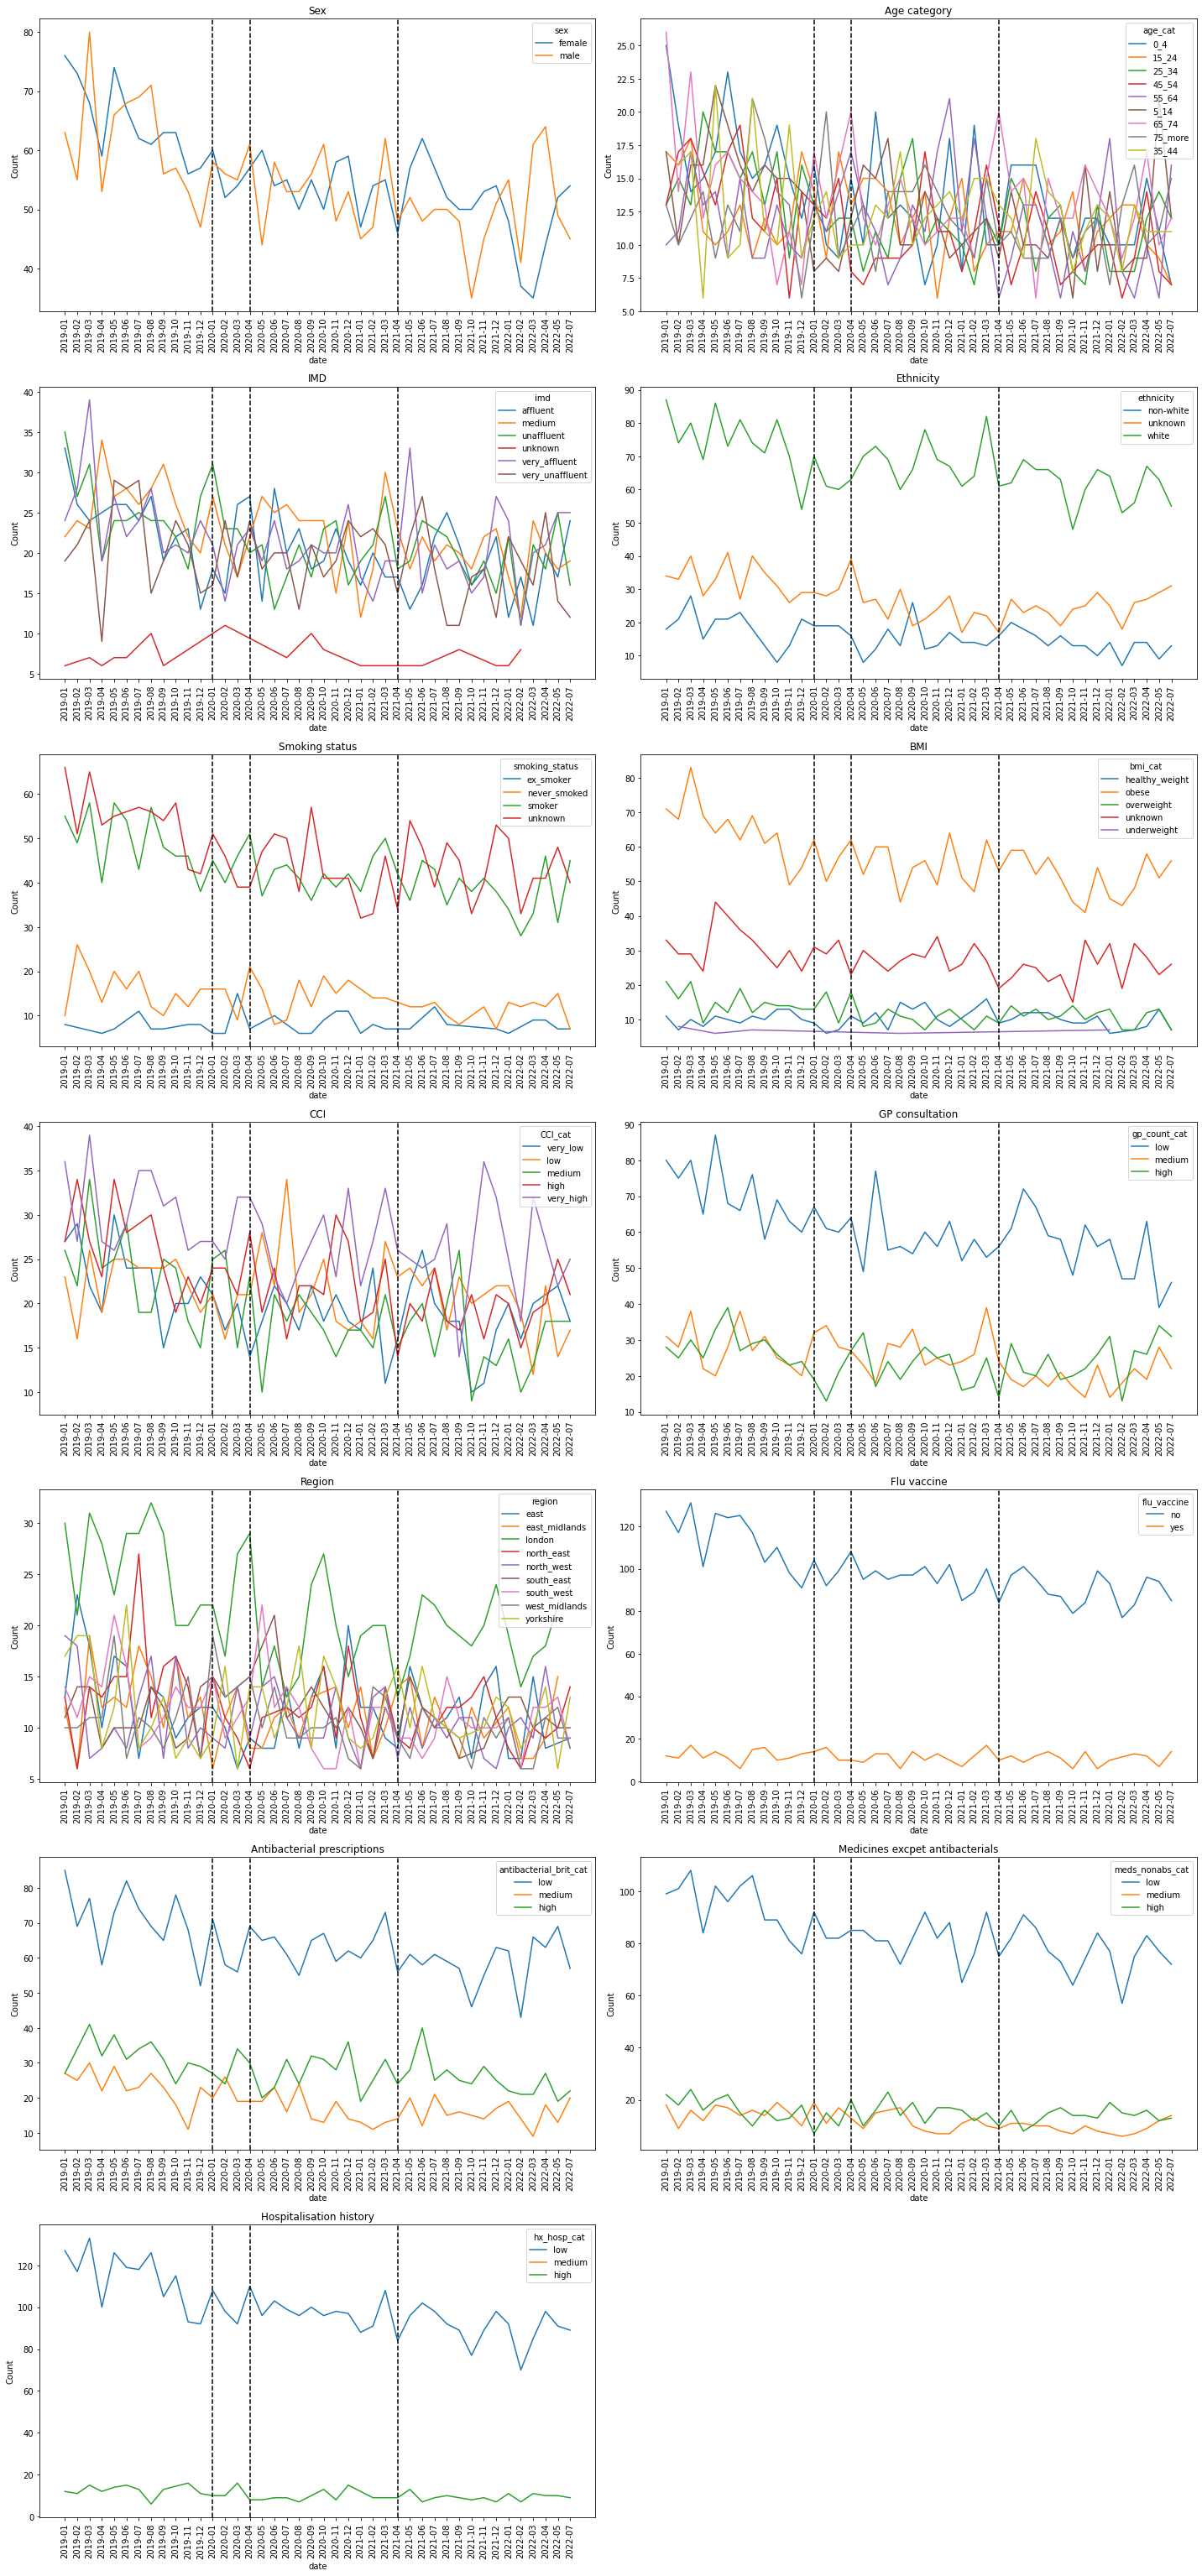

In [ ]:
fig, axes = plt.subplots(6,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_lrti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_lrti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_lrti, 'imd', 'IMD', axes[1,0])
create_lineplot(data_lrti, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_lrti, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_lrti, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_lrti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_lrti, 'gp_count_cat', 'GP consultation', axes[3,1])
create_lineplot(data_lrti, 'region', 'Region', axes[4,0])
create_lineplot(data_lrti, 'flu_vaccine', 'Flu vaccine', axes[4,1])
create_lineplot(data_lrti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_lrti, 'meds_nonabs_cat', 'Medicines excpet antibacterials', axes[5,1])
create_lineplot(data_lrti, 'hx_hosp_cat', 'Hospitalisation history', axes[5,1])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors of lrti patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/risk_factors_cat_lrti.jpg')
plt.show()

## 4- Separate data of incident/prevalent and with/without antibiotics
We separate data of lrti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [103]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 
                        'smoking_status', 'season', #'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',
                        'antibacterial_brit', 'gp_count', #'meds_nonabs', 'hx_hosp',
                        'event_lrti_admitted', 'duration_lrti_admitted',
                        'lrti_ab_date', 'incdt_lrti_date',
                        'date']]

data_lrti.shape

(160149, 17)

In [105]:
# no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].isnull()] #gp_cons_lrti_ab
data_lrti_no_abs_incdt = data_lrti_no_abs_incdt[data_lrti_no_abs_incdt['incdt_lrti_date'] == 0]

# with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_incdt = data_lrti_abs_incdt[data_lrti_abs_incdt['incdt_lrti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_prevl = data_lrti_no_abs_prevl[data_lrti_no_abs_prevl['incdt_lrti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_prevl = data_lrti_abs_prevl[data_lrti_abs_prevl['incdt_lrti_date'] == 1]

print(f'shape of data_lrti_no_abs_incdt: {data_lrti_no_abs_incdt.shape}')
print(f'shape of data_lrti_abs_incdt: {data_lrti_abs_incdt.shape}')
print(f'shape of data_lrti_no_abs_prevl: {data_lrti_no_abs_prevl.shape}')
print(f'shape of data_lrti_abs_prevl: {data_lrti_abs_prevl.shape}')

shape of data_lrti_no_abs_incdt: (129778, 17)
shape of data_lrti_abs_incdt: (14435, 17)
shape of data_lrti_no_abs_prevl: (14332, 17)
shape of data_lrti_abs_prevl: (1604, 17)


In [106]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


In [107]:
print(f'shape of data_lrti_no_abs_incdt: \n{data_lrti_no_abs_incdt.event_lrti_admitted.value_counts()}')
print(f'shape of data_lrti_abs_incdt: \n{data_lrti_abs_incdt.event_lrti_admitted.value_counts()}')
print(f'shape of data_lrti_no_abs_prevl: \n{data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()}')
print(f'shape of data_lrti_abs_prevl: \n{data_lrti_abs_prevl.event_lrti_admitted.value_counts()}')

shape of data_lrti_no_abs_incdt: 
0.0    129588
1.0       190
Name: event_lrti_admitted, dtype: int64
shape of data_lrti_abs_incdt: 
0.0    14414
1.0       21
Name: event_lrti_admitted, dtype: int64
shape of data_lrti_no_abs_prevl: 
0.0    14311
1.0       21
Name: event_lrti_admitted, dtype: int64
shape of data_lrti_abs_prevl: 
0.0    1600
1.0       4
Name: event_lrti_admitted, dtype: int64


In [108]:
# save data shape
a = open("../output/hospitalisation_prediction_lrti/data_shape_cph_lrti.txt", "w")
a.write("")
a.writelines(['data_lrti_no_abs_incdt #observations, #events: %.0f' % (data_lrti_no_abs_incdt.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_no_abs_incdt.event_lrti_admitted.value_counts()[1]),
              '\ndata_lrti_abs_incdt #observations, #events: %.0f' % (data_lrti_abs_incdt.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_abs_incdt.event_lrti_admitted.value_counts()[1]),
              '\ndata_lrti_no_abs_prevl #observations, #events: %.0f' % (data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()[1]),
              '\ndata_lrti_abs_prevl #observations, #events: %.0f' % (data_lrti_abs_prevl.event_lrti_admitted.value_counts()[0]), ', %.0f' % (data_lrti_abs_prevl.event_lrti_admitted.value_counts()[1])
              ])

## 5- Cox modelling for hospital admissions related to infections 
### 5-1- lrti
#### 5-1-1- Incident hospital admission related to lrti with no antibiotics

In [109]:
#keep relevant variables
data_lrti_no_abs_incdt = data_lrti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                                 'imd', 'ethnicity', 'smoking_status', 'season', 
                                                # 'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',                                               
                                                 'antibacterial_brit', 'gp_count', #'meds_nonabs', 'hx_hosp',
                                                 'event_lrti_admitted', 'duration_lrti_admitted']]

data_lrti_no_abs_incdt.shape

(129778, 14)

In [110]:
# encoding categorical data for CPH
data = data_lrti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_lrti_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_lrti_no_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_lrti_no_abs_incdt_enc = data[['antibacterial_brit', 'gp_count']].join(data_lrti_no_abs_incdt_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_lrti_admitted', 'duration_lrti_admitted'

data_lrti_no_abs_incdt_enc.head()

,antibacterial_brit,gp_count,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,...,ethnicity_unknown,ethnicity_white,smoking_status_ex_smoker,smoking_status_never_smoked,smoking_status_smoker,smoking_status_unknown,season_autumn,season_spring,season_summer,season_winter
0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,4.0,10.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [111]:
# #summary table
# summary_table_lrti_no_abs_incdt = data_lrti_no_abs_incdt_enc.sum(axis=0).reset_index()
# summary_table_lrti_no_abs_incdt.columns = ['variable', 'count']
# #replace small counts (<=5) with 'SM'
# summary_table_lrti_no_abs_incdt.loc[(summary_table_lrti_no_abs_incdt['count'] <= 5), 'count'] = 'SM'
# summary_table_lrti_no_abs_incdt['mean'] = data_lrti_no_abs_incdt_enc.mean(axis=0).reset_index()[0]
# # summary_table_lrti_no_abs_incdt

# # save table
# summary_table_lrti_no_abs_incdt.to_csv('../output/hospitalisation_prediction_lrti/summary_table_lrti_no_abs_incdt.csv', index=False)

In [112]:
#summary table
summary_table_lrti_no_abs_incdt = data_lrti_no_abs_incdt_enc.sum(axis=0).reset_index()
summary_table_lrti_no_abs_incdt.columns = ['variable', 'count']
#round count to make last digit either 0 or 5
summary_table_lrti_no_abs_incdt['mean'] = data_lrti_no_abs_incdt_enc.mean(axis=0).reset_index()[0]
summary_table_lrti_no_abs_incdt['count'] = round_five_mul(summary_table_lrti_no_abs_incdt['count'], base=5)
summary_table_lrti_no_abs_incdt['std'] = data_lrti_no_abs_incdt_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_lrti_no_abs_incdt.loc[(summary_table_lrti_no_abs_incdt['count'] <= 5), 'count'] = 'SM'
# summary_table_lrti_no_abs_incdt

# save table
summary_table_lrti_no_abs_incdt.to_csv('../output/hospitalisation_prediction_lrti/summary_table_lrti_no_abs_incdt.csv', index=False)

In [113]:
#randomly splitting data into training (%75) and testing (%25)
data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test = train_test_split(data_lrti_no_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_lrti_no_abs_incdt for training: {data_lrti_no_abs_incdt_train.shape}')
print(f'shape of data_lrti_no_abs_incdt for testing: {data_lrti_no_abs_incdt_test.shape}')

shape of data_lrti_no_abs_incdt for training: (97333, 14)
shape of data_lrti_no_abs_incdt for testing: (32445, 14)


In [114]:
cph_lrti_no_abs_incdt = CoxPHFitter()
cph_lrti_no_abs_incdt.fit(data_lrti_no_abs_incdt_train,
        duration_col='duration_lrti_admitted',
        event_col='event_lrti_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + gp_count"# + meds_nonabs + hx_hosp 
        )
cph_lrti_no_abs_incdt.print_summary()

#save model output
output = GetPrintSummary(cph_lrti_no_abs_incdt)
with open('../output/hospitalisation_prediction_lrti/cph_lrti_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

<lifelines.CoxPHFitter: fitted with 97333 total observations, 97185 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 97333
number of events observed = 148
   partial log-likelihood = -1677.33
         time fit was run = 2022-08-31 13:31:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.28            -0.69             0.40                 0.50                 1.49
CCI_cat[T.medium]                0.16       1.18       0.26            -0.35             0.68                 0.70                 1.97
CCI_cat[T.high]                  0.04       1.04       0.26            -0.47             0.55                 0.62                 1.73
CCI_cat[T.very_high]            -0.12       0.89       0.25            -0.61             0.38                 0.54                 1.46
age_cat[T.15_24]                 0.31       1.36       0.34            -0.35             0.96                 0.70                 2.62
age_cat[T.25_34]                -0.64       0.53       0.43            -1.49             0.21                 0.23                 1.24
age_cat[T.35_44]                -0.14       0.87       0.37            -0.87             0.59                 0.42                 1.81
age_cat[T.45_54]                 0.12       1.13       0.35            -0.56             0.81                 0.57                 2.24
age_cat[T.55_64]                 0.31       1.37       0.34            -0.34             0.97                 0.71                 2.64
age_cat[T.5_14]                  0.17       1.19       0.34            -0.50             0.85                 0.61                 2.33
age_cat[T.65_74]                -0.19       0.82       0.38            -0.94             0.55                 0.39                 1.74
age_cat[T.75_more]               0.48       1.62       0.32            -0.15             1.12                 0.86                 3.05
antibacterial_brit               0.04       1.04       0.06            -0.07             0.15                 0.93                 1.16
bmi_cat[T.obese]                -0.53       0.59       0.25            -1.02            -0.03                 0.36                 0.97
bmi_cat[T.overweight]           -0.82       0.44       0.37            -1.54            -0.10                 0.22                 0.90
bmi_cat[T.underweight]          -0.25       0.78       0.47            -1.16             0.66                 0.31                 1.94
bmi_cat[T.unknown]              -0.50       0.61       0.28            -1.05             0.04                 0.35                 1.04
ethnicity[T.unknown]             0.17       1.19       0.28            -0.38             0.73                 0.69                 2.07
ethnicity[T.white]               0.17       1.19       0.25            -0.32             0.67                 0.72                 1.94
flu_vaccine[T.yes]               0.25       1.28       0.25            -0.24             0.74                 0.78                 2.10
gp_count                         0.02       1.02       0.02            -0.02             0.07                 0.98                 1.07
imd[T.medium]                   -0.21       0.81       0.26            -0.72             0.30                 0.48                 1.36
imd[T.unaffluent]               -0.09       0.92       0.25            -0.58             0.41                 0.56                 1.51
imd[T.unknown]                  -0.54       0.58       0.48            -1.48             0.40                 0.23                 1.49
imd[T.very_affluent]            -0.51       0.60       0.28         

13576


In [62]:
cph_lrti_no_abs_incdt.log_likelihood_
# cph_lrti_no_abs_incdt.AIC_partial_
# cph_lrti_no_abs_incdt.score(data_lrti_no_abs_incdt_train, scoring_method='log_likelihood')

-197.02423023553334

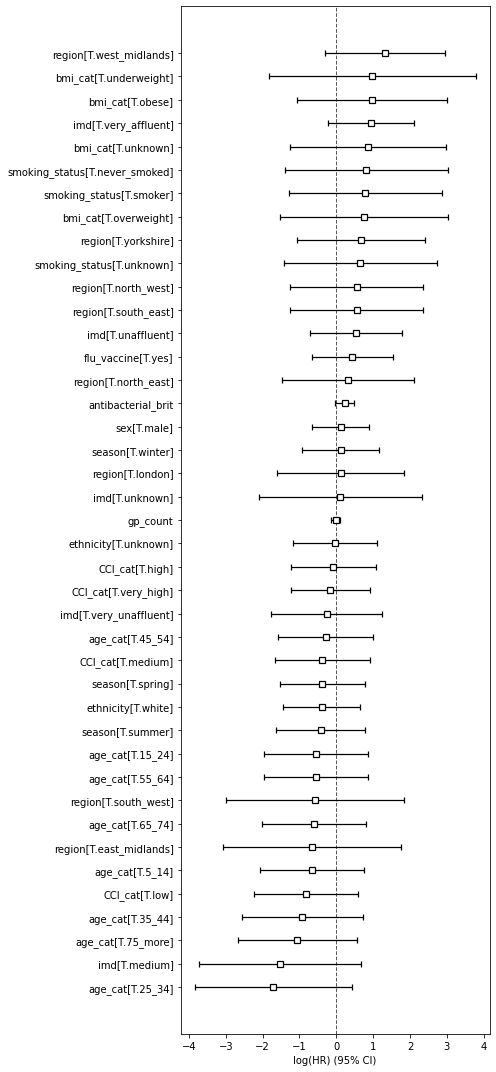

In [63]:
# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_lrti_no_abs_incdt.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to lrti with no antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/coef_cph_lrti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [64]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_lrti_no_abs_incdt.hazard_ratios_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
# covariates.shape

# save coefficients
covariates.to_csv('../output/hospitalisation_prediction_lrti/betas_cph_lrti_no_abs_incdt.csv', index=False)

# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# covariatesT.shape

# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

#match mylist (covariates of cox model) with encoded data
data = data_lrti_no_abs_incdt_enc[data_lrti_no_abs_incdt_enc.columns.intersection(mylist)] 
data = data.sort_index(axis = 1) #sort 
# data.shape

# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
# betas

# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
# sum_betas

In [65]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_lrti_no_abs_incdt.predict_cumulative_hazard(data_lrti_no_abs_incdt).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
# sum_betas_hazard

# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# sum_betas_hazard

# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# sum_betas_hazard

#calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# sum_betas_hazard_groupby

#calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bins
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# sum_betas_hazard_groupby.head()

# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate']]

# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_lrti/sum_betas_cph_lrti_no_abs_incdt.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_lrti/sum_betas_cph_lrti_no_abs_incdt.txt', sum_betas, delimiter=',')

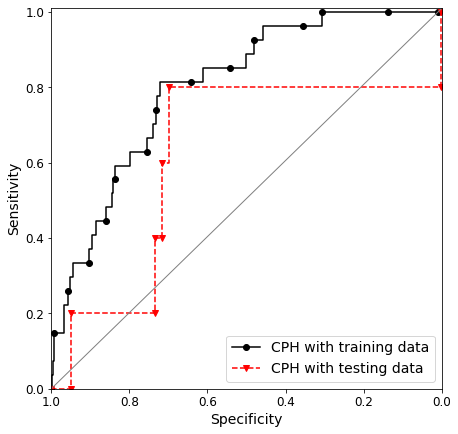

In [66]:
# analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_lrti_no_abs_incdt_train_cumulative_hazard = cph_lrti_no_abs_incdt.predict_cumulative_hazard(data_lrti_no_abs_incdt_train)
cph_lrti_no_abs_incdt_train_cumulative_hazard = cph_lrti_no_abs_incdt_train_cumulative_hazard.loc[[30]].T
cph_lrti_no_abs_incdt_train_cumulative_hazard['event_lrti_admitted'] = data_lrti_no_abs_incdt_train['event_lrti_admitted']
cph_lrti_no_abs_incdt_train_cumulative_hazard = cph_lrti_no_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_lrti_no_abs_incdt_train_cumulative_hazard

# analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_lrti_no_abs_incdt_test_cumulative_hazard = cph_lrti_no_abs_incdt.predict_cumulative_hazard(data_lrti_no_abs_incdt_test)
cph_lrti_no_abs_incdt_test_cumulative_hazard = cph_lrti_no_abs_incdt_test_cumulative_hazard.loc[[30]].T
cph_lrti_no_abs_incdt_test_cumulative_hazard['event_lrti_admitted'] = data_lrti_no_abs_incdt_test['event_lrti_admitted']
cph_lrti_no_abs_incdt_test_cumulative_hazard = cph_lrti_no_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_lrti_no_abs_incdt_test_cumulative_hazard

# plot roc curves
r_fpr1, r_tpr1, _ = roc_curve(cph_lrti_no_abs_incdt_train_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_lrti_no_abs_incdt_test_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \nlrti with no antibiotics', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/roc_cph_lrti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [67]:
#predict cumulative hazard in day 30
prob_pred_true_train = cph_lrti_no_abs_incdt.predict_cumulative_hazard(data_lrti_no_abs_incdt_train).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
prob_pred_true_train.columns = ['pred']
prob_pred_true_train

,pred
6006,0.007363
3717,0.004743
3476,0.003768
1155,0.015428
6498,0.011181
...,...
2173,0.007679
2489,0.005360
1625,0.002303
6693,0.005881


In [68]:
#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
prob_pred_true_train

,pred,bins
6006,0.007363,"(0.00699, 0.00973]"
3717,0.004743,"(0.00356, 0.00512]"
3476,0.003768,"(0.00356, 0.00512]"
1155,0.015428,"(0.0143, 0.0233]"
6498,0.011181,"(0.00973, 0.0143]"
...,...,...
2173,0.007679,"(0.00699, 0.00973]"
2489,0.005360,"(0.00512, 0.00699]"
1625,0.002303,"(0.00153, 0.0024]"
6693,0.005881,"(0.00512, 0.00699]"


In [69]:
#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_lrti_no_abs_incdt_train.event_lrti_admitted, left_index=True, right_index=True)
prob_pred_true_train

,pred,bins,event_lrti_admitted
6006,0.007363,"(0.00699, 0.00973]",0.0
3717,0.004743,"(0.00356, 0.00512]",0.0
3476,0.003768,"(0.00356, 0.00512]",0.0
1155,0.015428,"(0.0143, 0.0233]",0.0
6498,0.011181,"(0.00973, 0.0143]",0.0
...,...,...,...
2173,0.007679,"(0.00699, 0.00973]",0.0
2489,0.005360,"(0.00512, 0.00699]",0.0
1625,0.002303,"(0.00153, 0.0024]",0.0
6693,0.005881,"(0.00512, 0.00699]",0.0


In [70]:
#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
prob_pred_true_train_groupby_bin

,bins,pred_mean,pred_sum,pred_count,event_mean,event_sum,event_count
0,"(-0.0009530000000000001, 0.000845]",0.000521,0.146412,281,0.000000,0.0,281
1,"(0.000845, 0.00153]",0.001192,0.335047,281,0.000000,0.0,281
2,"(0.00153, 0.0024]",0.001953,0.548766,281,0.000000,0.0,281
3,"(0.0024, 0.00356]",0.002960,0.828844,280,0.003571,1.0,280
4,"(0.00356, 0.00512]",0.004294,1.206651,281,0.010676,3.0,281
5,"(0.00512, 0.00699]",0.006005,1.687348,281,0.000000,0.0,281
6,"(0.00699, 0.00973]",0.008200,2.295983,280,0.003571,1.0,280
7,"(0.00973, 0.0143]",0.011824,3.322474,281,0.021352,6.0,281
8,"(0.0143, 0.0233]",0.018030,5.066529,281,0.021352,6.0,281
9,"(0.0233, 0.158]",0.042411,11.917385,281,0.035587,10.0,281


In [71]:
#calculate proportion of events in each bin
# prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_sum.sum()
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
prob_pred_true_train_groupby_bin

,bins,pred_mean,pred_sum,pred_count,event_mean,event_sum,event_count,event_proportion
0,"(-0.0009530000000000001, 0.000845]",0.000521,0.146412,281,0.000000,0.0,281,0.000000
1,"(0.000845, 0.00153]",0.001192,0.335047,281,0.000000,0.0,281,0.000000
2,"(0.00153, 0.0024]",0.001953,0.548766,281,0.000000,0.0,281,0.000000
3,"(0.0024, 0.00356]",0.002960,0.828844,280,0.003571,1.0,280,0.003571
4,"(0.00356, 0.00512]",0.004294,1.206651,281,0.010676,3.0,281,0.010676
5,"(0.00512, 0.00699]",0.006005,1.687348,281,0.000000,0.0,281,0.000000
6,"(0.00699, 0.00973]",0.008200,2.295983,280,0.003571,1.0,280,0.003571
7,"(0.00973, 0.0143]",0.011824,3.322474,281,0.021352,6.0,281,0.021352
8,"(0.0143, 0.0233]",0.018030,5.066529,281,0.021352,6.0,281,0.021352
9,"(0.0233, 0.158]",0.042411,11.917385,281,0.035587,10.0,281,0.035587


In [72]:
#predict cumulative hazard in day 30
prob_pred_true_test = cph_lrti_no_abs_incdt.predict_cumulative_hazard(data_lrti_no_abs_incdt_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_lrti_no_abs_incdt_test.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
prob_pred_true_test_groupby_bin

,bins,pred_mean,pred_sum,pred_count,event_mean,event_sum,event_count,event_proportion
0,"(-0.00094, 0.000969]",0.000559,0.052544,94,0.010638,1.0,94,0.010638
1,"(0.000969, 0.00193]",0.001451,0.136365,94,0.000000,0.0,94,0.000000
2,"(0.00193, 0.00284]",0.002345,0.218108,93,0.000000,0.0,93,0.000000
3,"(0.00284, 0.004]",0.003317,0.311762,94,0.000000,0.0,94,0.000000
4,"(0.004, 0.00549]",0.004723,0.439245,93,0.000000,0.0,93,0.000000
5,"(0.00549, 0.00768]",0.006534,0.614179,94,0.000000,0.0,94,0.000000
6,"(0.00768, 0.0102]",0.008861,0.824067,93,0.010753,1.0,93,0.010753
7,"(0.0102, 0.0151]",0.012225,1.149104,94,0.021277,2.0,94,0.021277
8,"(0.0151, 0.0236]",0.018583,1.728185,93,0.000000,0.0,93,0.000000
9,"(0.0236, 0.11]",0.039683,3.730229,94,0.010638,1.0,94,0.010638


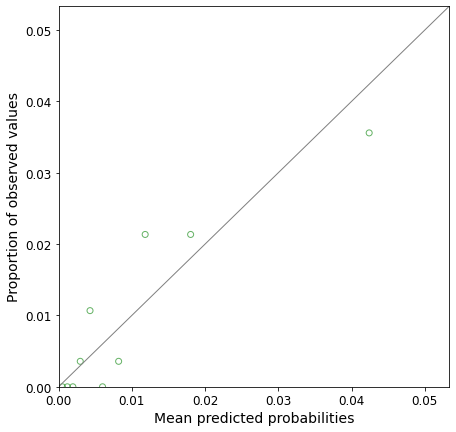

In [73]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_cph_lrti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

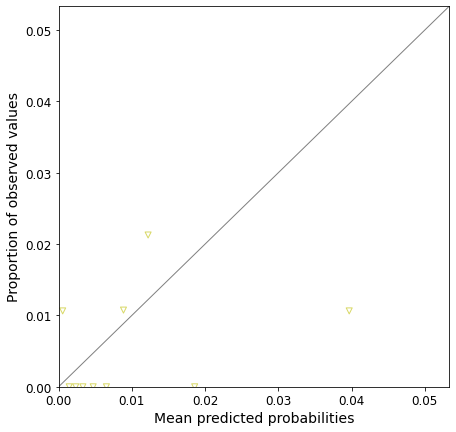

In [74]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_cph_lrti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [69]:
# fig, ax1 = plt.subplots(figsize=(7, 7))
# plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion_ii, marker='o')
# plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion_ii, marker='v')
# plt.xlabel('Mean predicted probabilities', fontsize=14)
# plt.ylabel('Proportion of observed values', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12, rotation=0)
# plt.xlim(0, 0.3)
# plt.ylim(0, 0.3)
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
# plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
# plt.savefig('../output/hospitalisation_prediction_lrti/calibration_cph_lrti_no_abs_incdt_ii.jpg', bbox_inches='tight')
# plt.show()

In [70]:
# fig, ax1 = pyplot.subplots(figsize=(7, 7))
# fop1, mpv1, = calibration_curve(cph_lrti_no_abs_incdt_train_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard, n_bins=10, strategy='quantile')
# fop2, mpv2, = calibration_curve(cph_lrti_no_abs_incdt_test_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard, n_bins=10, strategy='quantile')
# pyplot.plot(mpv1, fop1, marker='.', markersize=12, markevery=0.1, linestyle='-')
# pyplot.plot(mpv2, fop2, marker='.', markersize=12, markevery=0.1, linestyle='-')
# pyplot.xlabel('Predicted probabilities', fontsize=14)
# pyplot.ylabel('Observed values', fontsize=14)
# pyplot.xticks(fontsize=12)
# pyplot.yticks(fontsize=12, rotation=0)
# pyplot.xlim(0, 0.3)
# pyplot.ylim(0, 0.3)
# pyplot.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
# pyplot.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
# pyplot.savefig('../output/hospitalisation_prediction_lrti/calib_cph_lrti_no_abs_incdt.jpg', bbox_inches='tight')
# pyplot.show()

In [71]:
# fig, axe = plt.subplots(figsize=(8, 8))
# calib_cph_lrti_no_abs_incdt_train = CalibrationDisplay.from_predictions(cph_lrti_no_abs_incdt_train_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard, ax = axe)
# # plt.suptitle('Calibration of CPH model with training data of incident hospital admission \n related to lrti with no antibiotics', fontsize=16)
# plt.xlabel('Mean predicted probability', fontsize=14)
# plt.ylabel('Fraction of positives', fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.grid(visible=bool, linestyle='--')
# plt.xlim(0, 0.3)
# plt.ylim(0, 0.3)
# # plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_lrti/calib_cph_lrti_no_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

In [75]:
# calculate concordance index, AUROC, and Brier score of cph model
concord_index_lrti_no_abs_incdt_train = concordance_index(data_lrti_no_abs_incdt_train['duration_lrti_admitted'], -cph_lrti_no_abs_incdt.predict_partial_hazard(data_lrti_no_abs_incdt_train), data_lrti_no_abs_incdt_train['event_lrti_admitted'])
concord_index_lrti_no_abs_incdt_test = concordance_index(data_lrti_no_abs_incdt_test['duration_lrti_admitted'], -cph_lrti_no_abs_incdt.predict_partial_hazard(data_lrti_no_abs_incdt_test), data_lrti_no_abs_incdt_test['event_lrti_admitted'])
r_auc1 = roc_auc_score(cph_lrti_no_abs_incdt_train_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_lrti_no_abs_incdt_test_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_lrti_no_abs_incdt_train_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_lrti_no_abs_incdt_test_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

# save model outputs
a = open("../output/hospitalisation_prediction_lrti/cph_lrti_no_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['Concordance index for lrti_no_abs_incdt with testing data: %.4f' % (concord_index_lrti_no_abs_incdt_test), 
              '\nConcordance index for lrti_no_abs_incdt with training data: %.4f' % (concord_index_lrti_no_abs_incdt_train),
              '\nAUROC of CPH with training data of hospital admission related to incident lrti with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to incident lrti with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to incident lrti with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to incident lrti with no antibiotics = %.4f' % (brier2)])

#### 5-1-2- Incident hospital admission related to lrti with antibiotics

In [76]:
#keep relevant variables
data_lrti_abs_incdt = data_lrti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                           'imd', 'ethnicity', 'smoking_status', 'season', 
                                        #    'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat', 
                                           'antibacterial_brit', 'gp_count',  #'meds_nonabs', 'hx_hosp', 
                                           'event_lrti_admitted', 'duration_lrti_admitted']]

In [77]:
# encoding categorical data for CPH
data = data_lrti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_lrti_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_lrti_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_lrti_abs_incdt_enc = data[['antibacterial_brit', 'gp_count']].join(data_lrti_abs_incdt_enc) # , 'meds_nonabs', 'hx_hosp', 'event_lrti_admitted', 'duration_lrti_admitted'

data_lrti_abs_incdt_enc.head()

,antibacterial_brit,gp_count,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,...,ethnicity_unknown,ethnicity_white,smoking_status_ex_smoker,smoking_status_never_smoked,smoking_status_smoker,smoking_status_unknown,season_autumn,season_spring,season_summer,season_winter
0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,4.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [78]:
# #summary table
# summary_table_lrti_abs_incdt = data_lrti_abs_incdt_enc.sum(axis=0).reset_index()
# summary_table_lrti_abs_incdt.columns = ['variable', 'count']
# summary_table_lrti_abs_incdt['mean'] = data_lrti_abs_incdt_enc.mean(axis=0).reset_index()[0]
# # summary_table_lrti_no_abs_incdt

# # save table
# summary_table_lrti_abs_incdt.to_csv('../output/hospitalisation_prediction_lrti/summary_table_lrti_abs_incdt.csv', index=False)

In [79]:
#summary table
summary_table_lrti_abs_incdt = data_lrti_abs_incdt_enc.sum(axis=0).reset_index()
summary_table_lrti_abs_incdt.columns = ['variable', 'count']
#round count to make last digit either 0 or 5
summary_table_lrti_abs_incdt['mean'] = data_lrti_abs_incdt_enc.mean(axis=0).reset_index()[0]
summary_table_lrti_abs_incdt['count'] = round_five_mul(summary_table_lrti_abs_incdt['count'], base=5)
summary_table_lrti_abs_incdt['std'] = data_lrti_abs_incdt_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_lrti_abs_incdt.loc[(summary_table_lrti_abs_incdt['count'] <= 5), 'count'] = 'SM'
# summary_table_lrti_abs_incdt

# save table
summary_table_lrti_abs_incdt.to_csv('../output/hospitalisation_prediction_lrti/summary_table_lrti_abs_incdt.csv', index=False)

In [80]:
#randomly splitting data into training (%75) and testing (%25)
data_lrti_abs_incdt_train, data_lrti_abs_incdt_test = train_test_split(data_lrti_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_lrti_abs_incdt for training: {data_lrti_abs_incdt_train.shape}')
print(f'shape of data_lrti_abs_incdt for testing: {data_lrti_abs_incdt_test.shape}')

shape of data_lrti_abs_incdt for training: (318, 14)
shape of data_lrti_abs_incdt for testing: (107, 14)


In [81]:
cph_lrti_abs_incdt = CoxPHFitter().fit(data_lrti_abs_incdt_train,
        duration_col='duration_lrti_admitted',
        event_col='event_lrti_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + gp_count "# + meds_nonabs + hx_hosp
        )
cph_lrti_abs_incdt.print_summary()

#save model summary
output = GetPrintSummary(cph_lrti_abs_incdt)
with open('../output/hospitalisation_prediction_lrti/cph_lrti_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

<lifelines.CoxPHFitter: fitted with 318 total observations, 313 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 318
number of events observed = 5
   partial log-likelihood = -6.69
         time fit was run = 2022-08-26 09:24:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       4.55            -8.82             9.02                 0.00              8290.30
CCI_cat[T.medium]               -1.92       0.15       5.52           -12.74             8.90                 0.00              7308.53
CCI_cat[T.high]                  1.88       6.54       3.93            -5.82             9.58                 0.00             14405.48
CCI_cat[T.very_high]             1.77       5.86       3.96            -5.99             9.52                 0.00             13683.50
age_cat[T.15_24]                 0.19       1.20      10.23           -19.86            20.24                 0.00             6.14e+08
age_cat[T.25_34]                 0.87       2.39      10.37           -19.46            21.20                 0.00             1.61e+09
age_cat[T.35_44]                -0.32       0.73      10.50           -20.89            20.26                 0.00             6.28e+08
age_cat[T.45_54]                 2.36      10.54       9.30           -15.88            20.59                 0.00             8.73e+08
age_cat[T.55_64]                 5.81     333.25       9.19           -12.21            23.83                 0.00             2.24e+10
age_cat[T.5_14]                  3.52      33.68      10.09           -16.25            23.28                 0.00             1.29e+10
age_cat[T.65_74]                 0.73       2.07      12.17           -23.13            24.59                 0.00             4.77e+10
age_cat[T.75_more]               4.07      58.60       9.85           -15.23            23.37                 0.00             1.41e+10
antibacterial_brit              -0.96       0.38       0.99            -2.91             0.98                 0.05                 2.67
bmi_cat[T.obese]                 4.60      99.17       8.45           -11.96            21.16                 0.00             1.54e+09
bmi_cat[T.overweight]           -1.81       0.16      10.55           -22.49            18.87                 0.00             1.56e+08
bmi_cat[T.underweight]           1.16       3.20      17.68           -33.50            35.82                 0.00             3.62e+15
bmi_cat[T.unknown]               3.39      29.67       8.42           -13.12            19.90                 0.00             4.38e+08
ethnicity[T.unknown]             0.16       1.18       5.44           -10.49            10.82                 0.00             49767.59
ethnicity[T.white]               2.29       9.84       3.46            -4.49             9.06                 0.01              8591.95
flu_vaccine[T.yes]               0.26       1.29       7.17           -13.79            14.30                 0.00             1.63e+06
gp_count                         0.13       1.14       0.53            -0.91             1.17                 0.40                 3.22
imd[T.medium]                    3.77      43.43       5.89            -7.76            15.31                 0.00             4.44e+06
imd[T.unaffluent]                0.52       1.69       6.62           -12.44            13.49                 0.00             7.22e+05
imd[T.unknown]                   0.41       1.51      10.89           -20.93            21.75                 0.00             2.81e+09
imd[T.very_affluent]             4.62     101.82       4.02            -3.26   

13779


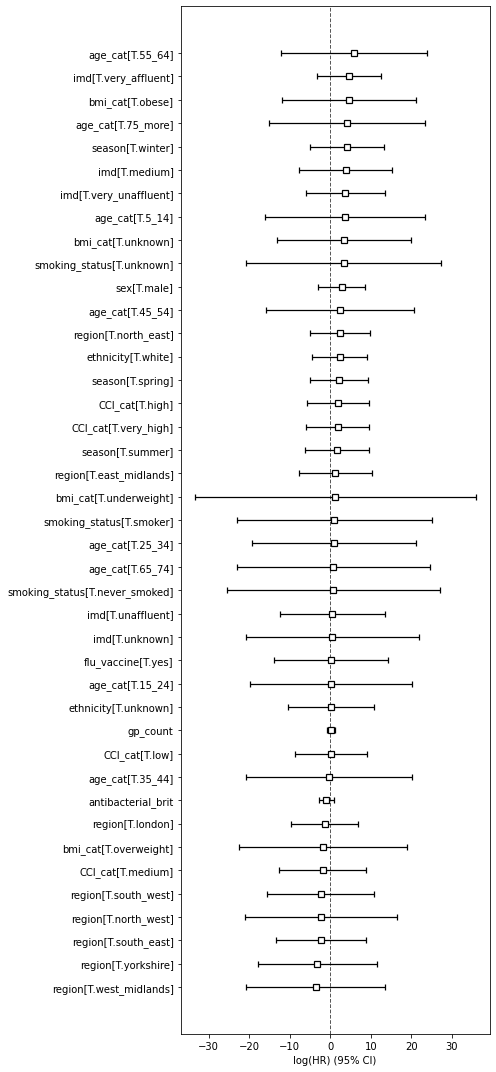

In [82]:
# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_lrti_abs_incdt.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to lrti with antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/coef_cph_lrti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [83]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_lrti_abs_incdt.hazard_ratios_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
# covariates.shape

# save coefficients
covariates.to_csv('../output/hospitalisation_prediction_lrti/betas_cph_lrti_abs_incdt.csv', index=False)

# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# covariatesT.shape

# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark

# match mylist (covariates of cox model) with encoded data
data = data_lrti_abs_incdt_enc[data_lrti_abs_incdt_enc.columns.intersection(mylist)] 
data = data.sort_index(axis = 1) #sort 
# data.shape

# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
# betas

# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
# sum_betas

In [84]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_lrti_abs_incdt.predict_cumulative_hazard(data_lrti_abs_incdt).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
# sum_betas_hazard

# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# sum_betas_hazard

# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# sum_betas_hazard

# calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# sum_betas_hazard_groupby.head()

# calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bin
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# sum_betas_hazard_groupby.head()

# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard 
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate']]

# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_lrti/sum_betas_cph_lrti_abs_incdt.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_lrti/sum_betas_cph_lrti_abs_incdt.txt', sum_betas, delimiter=',')

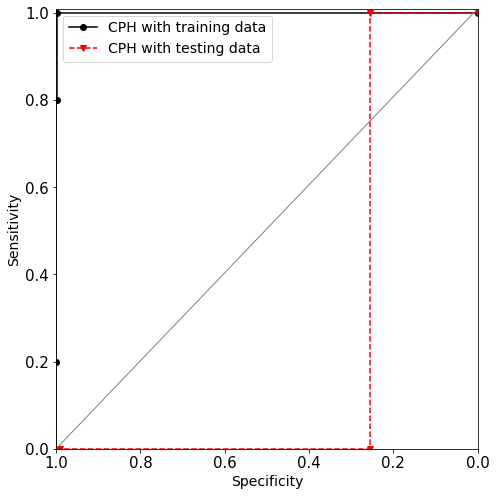

In [85]:
# analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event
cph_lrti_abs_incdt_train_cumulative_hazard = cph_lrti_abs_incdt.predict_cumulative_hazard(data_lrti_abs_incdt_train)
cph_lrti_abs_incdt_train_cumulative_hazard = cph_lrti_abs_incdt_train_cumulative_hazard.loc[[30]].T
cph_lrti_abs_incdt_train_cumulative_hazard['event_lrti_admitted'] = data_lrti_abs_incdt_train['event_lrti_admitted']
cph_lrti_abs_incdt_train_cumulative_hazard = cph_lrti_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_lrti_abs_incdt_train_cumulative_hazard

# analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event
cph_lrti_abs_incdt_test_cumulative_hazard = cph_lrti_abs_incdt.predict_cumulative_hazard(data_lrti_abs_incdt_test)
cph_lrti_abs_incdt_test_cumulative_hazard = cph_lrti_abs_incdt_test_cumulative_hazard.loc[[30]].T
cph_lrti_abs_incdt_test_cumulative_hazard['event_lrti_admitted'] = data_lrti_abs_incdt_test['event_lrti_admitted']
cph_lrti_abs_incdt_test_cumulative_hazard = cph_lrti_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_lrti_abs_incdt_test_cumulative_hazard

# plot roc curves
r_fpr1, r_tpr1, _ = roc_curve(cph_lrti_abs_incdt_train_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_lrti_abs_incdt_test_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_incdt_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \nlrti with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/roc_cph_lrti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [86]:
#predict cumulative hazard in day 30
prob_pred_true_train = cph_lrti_abs_incdt.predict_cumulative_hazard(data_lrti_abs_incdt_train).loc[[30]].T
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_lrti_abs_incdt_train.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin

In [87]:
#predict cumulative hazard in day 30
prob_pred_true_test = cph_lrti_abs_incdt.predict_cumulative_hazard(data_lrti_abs_incdt_test).loc[[30]].T
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_lrti_abs_incdt_test.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

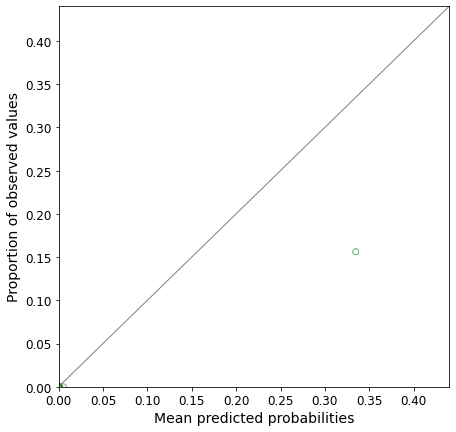

In [88]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_cph_lrti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

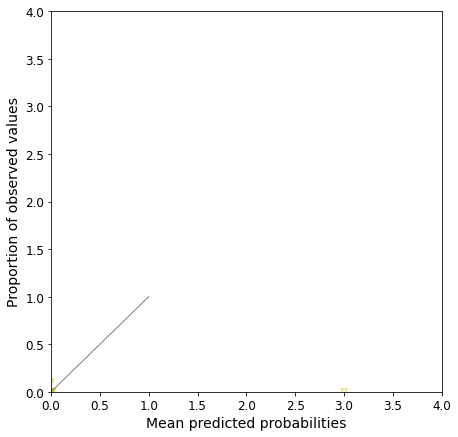

In [89]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_cph_lrti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [91]:
# calculate concordance index, AUROC, and Brier score of cph model 
concord_index_lrti_abs_incdt_train = concordance_index(data_lrti_abs_incdt_train['duration_lrti_admitted'], -cph_lrti_abs_incdt.predict_partial_hazard(data_lrti_abs_incdt_train), data_lrti_abs_incdt_train['event_lrti_admitted'])
concord_index_lrti_abs_incdt_test = concordance_index(data_lrti_abs_incdt_test['duration_lrti_admitted'], -cph_lrti_abs_incdt.predict_partial_hazard(data_lrti_abs_incdt_test), data_lrti_abs_incdt_test['event_lrti_admitted'])
r_auc1 = roc_auc_score(cph_lrti_abs_incdt_train_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_lrti_abs_incdt_test_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_incdt_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_lrti_abs_incdt_train_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_lrti_abs_incdt_test_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_incdt_test_cumulative_hazard.cumulative_hazard)

# save model outputs
a = open("../output/hospitalisation_prediction_lrti/cph_lrti_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['Concordance index for lrti_abs_incdt with testing data: %.4f' % (concord_index_lrti_abs_incdt_test), 
              '\nConcordance index for lrti_abs_incdt with training data: %.4f' % (concord_index_lrti_abs_incdt_train),
              '\nAUROC of CPH with training data of hospital admission related to incident lrti with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to incident lrti with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to incident lrti with antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to incident lrti with antibiotics = %.4f' % (brier2)])

#### 5-1-3- Prevalent hospital admission related to lrti with no antibiotics

In [92]:
#keep relevant variables
data_lrti_no_abs_prevl = data_lrti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                                 'imd', 'ethnicity', 'smoking_status', 'season', 
                                                # 'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',                                               
                                                 'antibacterial_brit', 'gp_count', #'meds_nonabs', 'hx_hosp',
                                                 'event_lrti_admitted', 'duration_lrti_admitted']]

data_lrti_no_abs_prevl.shape

(424, 14)

In [93]:
# encoding categorical data for CPH
data = data_lrti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_lrti_no_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_lrti_no_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_lrti_no_abs_prevl_enc = data[['antibacterial_brit', 'gp_count']].join(data_lrti_no_abs_prevl_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_lrti_admitted', 'duration_lrti_admitted'

data_lrti_no_abs_prevl_enc.head()

,antibacterial_brit,gp_count,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,...,ethnicity_unknown,ethnicity_white,smoking_status_ex_smoker,smoking_status_never_smoked,smoking_status_smoker,smoking_status_unknown,season_autumn,season_spring,season_summer,season_winter
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [94]:
# #summary table
# summary_table_lrti_no_abs_prevl = data_lrti_no_abs_prevl_enc.sum(axis=0).reset_index()
# summary_table_lrti_no_abs_prevl.columns = ['variable', 'count']
# summary_table_lrti_no_abs_prevl['mean'] = data_lrti_no_abs_prevl_enc.mean(axis=0).reset_index()[0]
# # summary_table_lrti_no_abs_prevl

# # save table
# summary_table_lrti_no_abs_prevl.to_csv('../output/hospitalisation_prediction_lrti/summary_table_lrti_no_abs_prevl.csv', index=False)

In [95]:
#summary table
summary_table_lrti_no_abs_prevl = data_lrti_no_abs_prevl_enc.sum(axis=0).reset_index()
summary_table_lrti_no_abs_prevl.columns = ['variable', 'count']
#round count to make last digit either 0 or 5
summary_table_lrti_no_abs_prevl['mean'] = data_lrti_no_abs_prevl_enc.mean(axis=0).reset_index()[0]
summary_table_lrti_no_abs_prevl['count'] = round_five_mul(summary_table_lrti_no_abs_prevl['count'], base=5)
summary_table_lrti_no_abs_prevl['std'] = data_lrti_no_abs_prevl_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_lrti_no_abs_prevl.loc[(summary_table_lrti_no_abs_prevl['count'] <= 5), 'count'] = 'SM'
# summary_table_lrti_no_abs_prevl

# save table
summary_table_lrti_no_abs_prevl.to_csv('../output/hospitalisation_prediction_lrti/summary_table_lrti_no_abs_prevl.csv', index=False)

In [96]:
#randomly splitting data into training (%75) and testing (%25)
data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test = train_test_split(data_lrti_no_abs_prevl, test_size=0.25, random_state=42)

print(f'shape of data_lrti_no_abs_prevl for training: {data_lrti_no_abs_prevl_train.shape}')
print(f'shape of data_lrti_no_abs_prevl for testing: {data_lrti_no_abs_prevl_test.shape}')

In [97]:
cph_lrti_no_abs_prevl = CoxPHFitter()
cph_lrti_no_abs_prevl.fit(data_lrti_no_abs_prevl_train,
        duration_col='duration_lrti_admitted',
        event_col='event_lrti_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + gp_count"# + meds_nonabs + hx_hosp 
        )
cph_lrti_no_abs_prevl.print_summary()

#save model output
output = GetPrintSummary(cph_lrti_no_abs_prevl)
with open('../output/hospitalisation_prediction_lrti/cph_lrti_no_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

In [98]:
# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_lrti_no_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to lrti with no antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/coef_cph_lrti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [99]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_lrti_no_abs_prevl.hazard_ratios_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
# covariates.shape

# save coefficients
covariates.to_csv('../output/hospitalisation_prediction_lrti/betas_cph_lrti_no_abs_prevl.csv', index=False)

# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# covariatesT.shape

# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

#match mylist (covariates of cox model) with encoded data
data = data_lrti_no_abs_prevl_enc[data_lrti_no_abs_prevl_enc.columns.intersection(mylist)] 
data = data.sort_index(axis = 1) #sort 
# data.shape

# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
# betas

# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
# sum_betas

In [100]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_lrti_no_abs_prevl.predict_cumulative_hazard(data_lrti_no_abs_prevl).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
# sum_betas_hazard

# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# sum_betas_hazard

# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# sum_betas_hazard

#calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# sum_betas_hazard_groupby

#calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bins
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# sum_betas_hazard_groupby.head()

# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate']]

# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_lrti/sum_betas_cph_lrti_no_abs_prevl.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_lrti/sum_betas_cph_lrti_no_abs_prevl.txt', sum_betas, delimiter=',')

In [101]:
# analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_lrti_no_abs_prevl_train_cumulative_hazard = cph_lrti_no_abs_prevl.predict_cumulative_hazard(data_lrti_no_abs_prevl_train)
cph_lrti_no_abs_prevl_train_cumulative_hazard = cph_lrti_no_abs_prevl_train_cumulative_hazard.loc[[30]].T
cph_lrti_no_abs_prevl_train_cumulative_hazard['event_lrti_admitted'] = data_lrti_no_abs_prevl_train['event_lrti_admitted']
cph_lrti_no_abs_prevl_train_cumulative_hazard = cph_lrti_no_abs_prevl_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_lrti_no_abs_prevl_train_cumulative_hazard

# analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_lrti_no_abs_prevl_test_cumulative_hazard = cph_lrti_no_abs_prevl.predict_cumulative_hazard(data_lrti_no_abs_prevl_test)
cph_lrti_no_abs_prevl_test_cumulative_hazard = cph_lrti_no_abs_prevl_test_cumulative_hazard.loc[[30]].T
cph_lrti_no_abs_prevl_test_cumulative_hazard['event_lrti_admitted'] = data_lrti_no_abs_prevl_test['event_lrti_admitted']
cph_lrti_no_abs_prevl_test_cumulative_hazard = cph_lrti_no_abs_prevl_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_lrti_no_abs_prevl_test_cumulative_hazard

# plot roc curves
r_fpr1, r_tpr1, _ = roc_curve(cph_lrti_no_abs_prevl_train_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_lrti_no_abs_prevl_test_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \nlrti with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/roc_cph_lrti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [102]:
#predict cumulative hazard in day 30
prob_pred_true_train = cph_lrti_no_abs_prevl.predict_cumulative_hazard(data_lrti_no_abs_prevl_train).loc[[30]].T
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_lrti_no_abs_prevl_train.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin

In [103]:
#predict cumulative hazard in day 30
prob_pred_true_test = cph_lrti_no_abs_prevl.predict_cumulative_hazard(data_lrti_no_abs_prevl_test).loc[[30]].T
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_lrti_no_abs_prevl_test.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [104]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_cph_lrti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [105]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_cph_lrti_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [106]:
# calculate concordance index, AUROC, and Brier score of cph model
concord_index_lrti_no_abs_prevl_train = concordance_index(data_lrti_no_abs_prevl_train['duration_lrti_admitted'], -cph_lrti_no_abs_prevl.predict_partial_hazard(data_lrti_no_abs_prevl_train), data_lrti_no_abs_prevl_train['event_lrti_admitted'])
concord_index_lrti_no_abs_prevl_test = concordance_index(data_lrti_no_abs_prevl_test['duration_lrti_admitted'], -cph_lrti_no_abs_prevl.predict_partial_hazard(data_lrti_no_abs_prevl_test), data_lrti_no_abs_prevl_test['event_lrti_admitted'])
r_auc1 = roc_auc_score(cph_lrti_no_abs_prevl_train_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_lrti_no_abs_prevl_test_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_lrti_no_abs_prevl_train_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_lrti_no_abs_prevl_test_cumulative_hazard.event_lrti_admitted, cph_lrti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

# save model outputs
a = open("../output/hospitalisation_prediction_lrti/cph_lrti_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['Concordance index for lrti_no_abs_prevl with testing data: %.4f' % (concord_index_lrti_no_abs_prevl_test), 
              '\nConcordance index for lrti_no_abs_prevl with training data: %.4f' % (concord_index_lrti_no_abs_prevl_train),
              '\nAUROC of CPH with training data of hospital admission related to prevalent lrti with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to prevalent lrti with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to prevalent lrti with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to prevalent lrti with no antibiotics = %.4f' % (brier2)])

#### 5-1-4- Prevalent hospital admission related to lrti with antibiotics

In [107]:
#keep relevant variables
data_lrti_abs_prevl = data_lrti_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                           'imd', 'ethnicity', 'smoking_status', 'season', 
                                        #    'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat', 
                                           'antibacterial_brit', 'gp_count',  #'meds_nonabs', 'hx_hosp', 
                                           'event_lrti_admitted', 'duration_lrti_admitted']]
data_lrti_abs_prevl.shape

(47, 14)

In [108]:
# encoding categorical data for CPH
data = data_lrti_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_lrti_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_lrti_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_lrti_abs_prevl_enc = data[['antibacterial_brit', 'gp_count']].join(data_lrti_abs_prevl_enc) # , 'meds_nonabs', 'hx_hosp', 'event_lrti_admitted', 'duration_lrti_admitted'

data_lrti_abs_prevl_enc.head()

,antibacterial_brit,gp_count,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,...,ethnicity_unknown,ethnicity_white,smoking_status_ex_smoker,smoking_status_never_smoked,smoking_status_smoker,smoking_status_unknown,season_autumn,season_spring,season_summer,season_winter
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [109]:
# #summary table
# summary_table_lrti_abs_prevl = data_lrti_abs_prevl_enc.sum(axis=0).reset_index()
# summary_table_lrti_abs_prevl.columns = ['variable', 'count']
# summary_table_lrti_abs_prevl['mean'] = data_lrti_abs_prevl_enc.mean(axis=0).reset_index()[0]
# # summary_table_lrti_abs_prevl

# # save table
# summary_table_lrti_abs_prevl.to_csv('../output/hospitalisation_prediction_lrti/summary_table_lrti_abs_prevl.csv', index=False)

In [110]:
#summary table
summary_table_lrti_abs_prevl = data_lrti_abs_prevl_enc.sum(axis=0).reset_index()
summary_table_lrti_abs_prevl.columns = ['variable', 'count']
#round count to make last digit either 0 or 5
summary_table_lrti_abs_prevl['mean'] = data_lrti_abs_prevl_enc.mean(axis=0).reset_index()[0]
summary_table_lrti_abs_prevl['count'] = round_five_mul(summary_table_lrti_abs_prevl['count'], base=5)
summary_table_lrti_abs_prevl['mean'] = data_lrti_abs_prevl_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_lrti_abs_prevl.loc[(summary_table_lrti_abs_prevl['count'] <= 5), 'count'] = 'SM'
# summary_table_lrti_abs_prevl

# save table
summary_table_lrti_abs_prevl.to_csv('../output/hospitalisation_prediction_lrti/summary_table_lrti_abs_prevl.csv', index=False)

In [111]:
#randomly splitting data into training (%75) and testing (%25)
data_lrti_abs_prevl_train, data_lrti_abs_prevl_test = train_test_split(data_lrti_abs_prevl, test_size=0.25, random_state=42)

print(f'shape of data_lrti_abs_prevl for training: {data_lrti_abs_prevl_train.shape}')
print(f'shape of data_lrti_abs_prevl for testing: {data_lrti_abs_prevl_test.shape}')

shape of data_lrti_abs_prevl for training: (35, 14)
shape of data_lrti_abs_prevl for testing: (12, 14)


In [113]:
cph_lrti_abs_prevl = CoxPHFitter().fit(data_lrti_abs_prevl_train,
        duration_col='duration_lrti_admitted',
        event_col='event_lrti_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + gp_count"# + meds_nonabs + hx_hosp"# + bmi_cat + antibacterial_brit_cat + meds_nonabs_cat + hx_hosp_cat"
        )
cph_lrti_abs_prevl.print_summary()

#save model output
output = GetPrintSummary(cph_lrti_abs_prevl)
with open('../output/hospitalisation_prediction_lrti/cph_lrti_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

In [ ]:
# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_lrti_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to lrti with antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/coef_cph_lrti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_lrti_abs_prevl.hazard_ratios_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
# covariates.shape

# save coefficients
covariates.to_csv('../output/hospitalisation_prediction_lrti/betas_cph_lrti_abs_prevl.csv', index=False)

# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# covariatesT.shape

# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark

# match mylist (covariates of cox model) with encoded data
data = data_lrti_abs_prevl_enc[data_lrti_abs_prevl_enc.columns.intersection(mylist)] 
data = data.sort_index(axis = 1) #sort 
# data.shape

# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
# betas

# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
# sum_betas

In [ ]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_lrti_abs_prevl.predict_cumulative_hazard(data_lrti_abs_prevl).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
# sum_betas_hazard

# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# sum_betas_hazard

# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# sum_betas_hazard

# calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# sum_betas_hazard_groupby.head()

# calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bin
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# sum_betas_hazard_groupby.head()

# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard 
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate']]

# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_lrti/sum_betas_cph_lrti_abs_prevl.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_lrti/sum_betas_cph_lrti_abs_prevl.txt', sum_betas, delimiter=',')

In [ ]:
# analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event
cph_lrti_abs_prevl_train_cumulative_hazard = cph_lrti_abs_prevl.predict_cumulative_hazard(data_lrti_abs_prevl_train)
cph_lrti_abs_prevl_train_cumulative_hazard = cph_lrti_abs_prevl_train_cumulative_hazard.loc[[30]].T
cph_lrti_abs_prevl_train_cumulative_hazard['event_lrti_admitted'] = data_lrti_abs_prevl_train['event_lrti_admitted']
cph_lrti_abs_prevl_train_cumulative_hazard = cph_lrti_abs_prevl_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_lrti_abs_prevl_train_cumulative_hazard

# analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event
cph_lrti_abs_prevl_test_cumulative_hazard = cph_lrti_abs_prevl.predict_cumulative_hazard(data_lrti_abs_prevl_test)
cph_lrti_abs_prevl_test_cumulative_hazard = cph_lrti_abs_prevl_test_cumulative_hazard.loc[[30]].T
cph_lrti_abs_prevl_test_cumulative_hazard['event_lrti_admitted'] = data_lrti_abs_prevl_test['event_lrti_admitted']
cph_lrti_abs_prevl_test_cumulative_hazard = cph_lrti_abs_prevl_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_lrti_abs_prevl_test_cumulative_hazard

# plot roc curves
r_fpr1, r_tpr1, _ = roc_curve(cph_lrti_abs_prevl_train_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_lrti_abs_prevl_test_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_prevl_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \nlrti with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/roc_cph_lrti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict cumulative hazard in day 30
prob_pred_true_train = cph_lrti_abs_prevl.predict_cumulative_hazard(data_lrti_abs_prevl_train).loc[[30]].T
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_lrti_abs_prevl_train.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin

In [ ]:
#predict cumulative hazard in day 30
prob_pred_true_test = cph_lrti_abs_prevl.predict_cumulative_hazard(data_lrti_abs_prevl_test).loc[[30]].T
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_lrti_abs_prevl_test.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_cph_lrti_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_cph_lrti_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# calculate concordance index, AUROC, and Brier score of cph model 
concord_index_lrti_abs_prevl_train = concordance_index(data_lrti_abs_prevl_train['duration_lrti_admitted'], -cph_lrti_abs_prevl.predict_partial_hazard(data_lrti_abs_prevl_train), data_lrti_abs_prevl_train['event_lrti_admitted'])
concord_index_lrti_abs_prevl_test = concordance_index(data_lrti_abs_prevl_test['duration_lrti_admitted'], -cph_lrti_abs_prevl.predict_partial_hazard(data_lrti_abs_prevl_test), data_lrti_abs_prevl_test['event_lrti_admitted'])
r_auc1 = roc_auc_score(cph_lrti_abs_prevl_train_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_lrti_abs_prevl_test_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_prevl_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_lrti_abs_prevl_train_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_prevl_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_lrti_abs_prevl_test_cumulative_hazard.event_lrti_admitted, cph_lrti_abs_prevl_test_cumulative_hazard.cumulative_hazard)

# save model outputs
a = open("../output/hospitalisation_prediction_lrti/cph_lrti_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['Concordance index for lrti_abs_prevl with testing data: %.4f' % (concord_index_lrti_abs_prevl_test), 
              '\nConcordance index for lrti_abs_prevl with training data: %.4f' % (concord_index_lrti_abs_prevl_train),
              '\nAUROC of CPH with training data of hospital admission related to prevalent lrti with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to prevalent lrti with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to prevalent lrti with antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to prevalent lrti with antibiotics = %.4f' % (brier2)])

## 6- Logistic regression
### 6-1- lrti
#### 6-1-1- Incident hospital admission related to lrti with no antibiotics

In [95]:
# encoding categorical data for LR
data = data_lrti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_lrti_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_lrti_no_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_lrti_no_abs_incdt_enc = data[['antibacterial_brit', 'gp_count']].join(data_lrti_no_abs_incdt_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_lrti_admitted', 'duration_lrti_admitted'

data_lrti_no_abs_incdt_enc.head()

,antibacterial_brit,gp_count,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,...,ethnicity_unknown,ethnicity_white,smoking_status_ex_smoker,smoking_status_never_smoked,smoking_status_smoker,smoking_status_unknown,season_autumn,season_spring,season_summer,season_winter
0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,3.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [96]:
#randomly splitting data into training (%75) and testing (%25)
data_lrti_no_abs_incdt_lr_X_train, data_lrti_no_abs_incdt_lr_X_test, data_lrti_no_abs_incdt_lr_y_train, data_lrti_no_abs_incdt_lr_y_test = train_test_split(data_lrti_no_abs_incdt_enc, data_lrti_no_abs_incdt.event_lrti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_lrti_no_abs_incdt_lr_X for training: {data_lrti_no_abs_incdt_lr_X_train.shape}')
print(f'shape of data_lrti_no_abs_incdt_lr_X for testing: {data_lrti_no_abs_incdt_lr_X_test.shape}')
print(f'shape of data_lrti_no_abs_incdt_lr_y for training: {data_lrti_no_abs_incdt_lr_y_train.shape}')
print(f'shape of data_lrti_no_abs_incdt_lr_y for testing: {data_lrti_no_abs_incdt_lr_y_test.shape}')

shape of data_lrti_no_abs_incdt_lr_X for training: (2892, 51)
shape of data_lrti_no_abs_incdt_lr_X for testing: (965, 51)
shape of data_lrti_no_abs_incdt_lr_y for training: (2892,)
shape of data_lrti_no_abs_incdt_lr_y for testing: (965,)


In [97]:
#build LR model
lr_lrti_no_abs_incdt = LogisticRegression().fit(data_lrti_no_abs_incdt_lr_X_train, data_lrti_no_abs_incdt_lr_y_train)

#prediction of hsopital admission related to lrti of training data using lr
pred_proba_lrti_no_abs_incdt_train = lr_lrti_no_abs_incdt.predict_proba(data_lrti_no_abs_incdt_lr_X_train)
# pred_proba_lrti_no_abs_incdt_train

#calculate score of lr_lrti_no_abs_incdt with training data
lr_lrti_no_abs_incdt_training_score = lr_lrti_no_abs_incdt.score(data_lrti_no_abs_incdt_lr_X_train, data_lrti_no_abs_incdt_lr_y_train)
print(f'score of lr_lrti_no_abs_incdt with training data: {lr_lrti_no_abs_incdt_training_score}')

#prediction of hsopital admission related to lrti of testing data using lr
pred_proba_lrti_no_abs_incdt_test = lr_lrti_no_abs_incdt.predict_proba(data_lrti_no_abs_incdt_lr_X_test)
# pred_proba_lrti_no_abs_incdt_test

#calculate score of lr_lrti_no_abs_incdt with testing data
lr_lrti_no_abs_incdt_testing_score = lr_lrti_no_abs_incdt.score(data_lrti_no_abs_incdt_lr_X_test, data_lrti_no_abs_incdt_lr_y_test)
print(f'score of lr_lrti_no_abs_incdt with testing data: {lr_lrti_no_abs_incdt_testing_score}')


score of lr_lrti_no_abs_incdt with training data: 0.9920470262793915
score of lr_lrti_no_abs_incdt with testing data: 0.9927461139896373


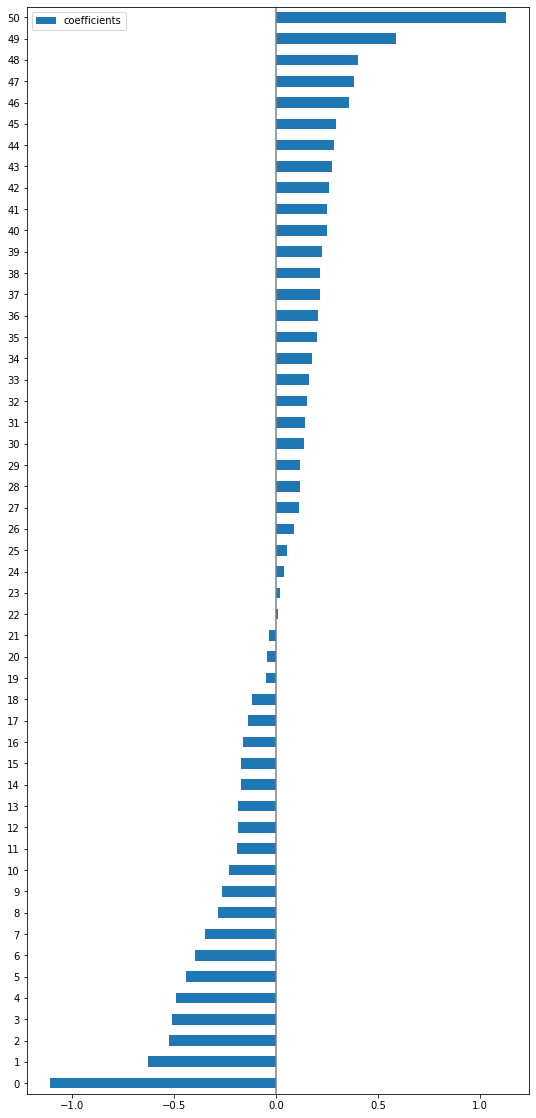

In [103]:
# set up coefficients of lr model
feature_names = lr_lrti_no_abs_incdt.feature_names_in_
coef = np.squeeze(lr_lrti_no_abs_incdt.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_lrti/coef_lr_lrti_no_abs_incdt.csv', index=False)

# obtain intercept
interc = lr_lrti_no_abs_incdt.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_lrti/intercept_lrti_no_abs_incdt.txt', interc, delimiter=',')

# plot coefficients 
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for incident hospital admission \n related to lrti with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/coef_lr_lrti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

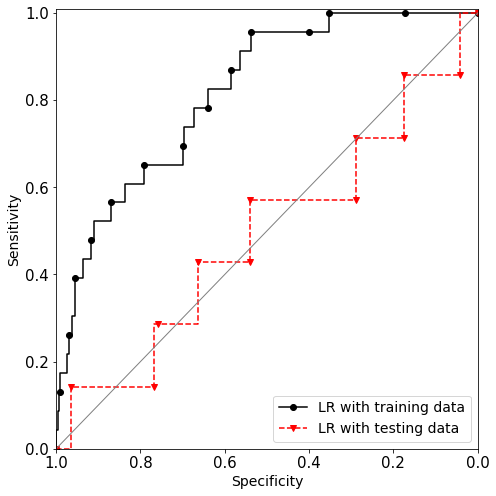

In [104]:
r_fpr1, r_tpr1, _ = roc_curve(data_lrti_no_abs_incdt_lr_y_train, pred_proba_lrti_no_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_lrti_no_abs_incdt_lr_y_test, pred_proba_lrti_no_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to incident \nlrti with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/roc_lr_lrti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [105]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_lrti_no_abs_incdt_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_lrti_no_abs_incdt_train.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin

In [106]:
#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_lrti_no_abs_incdt_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_lrti_no_abs_incdt_test.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

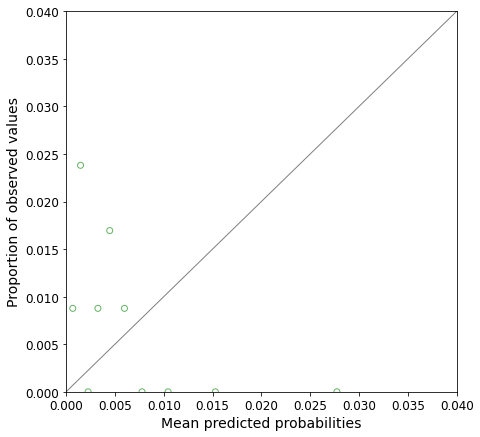

In [107]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_lr_lrti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

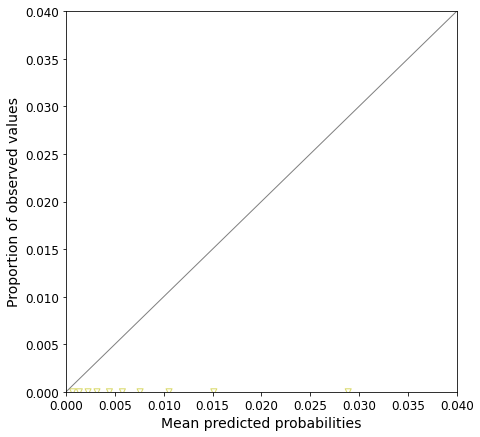

In [108]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_lr_lrti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [109]:
# fig, axe = plt.subplots(figsize=(8, 8))
# calib_lr_lrti_no_abs_incdt_train = CalibrationDisplay.from_predictions(data_lrti_no_abs_incdt_lr_y_train, pred_proba_lrti_no_abs_incdt_train[:,1], ax = axe)
# # plt.suptitle('Calibration of LR model with training data of incident hospital admission \n related to lrti with no antibiotics', fontsize=16)
# plt.xlabel('Mean predicted probability', fontsize=14)
# plt.ylabel('Fraction of positives', fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.grid(visible=bool, linestyle='--')
# plt.xlim(0, 0.1)
# plt.ylim(0, 0.1)
# # plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_lrti/calib_lr_lrti_no_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

In [110]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_lrti_no_abs_incdt_lr_y_train, pred_proba_lrti_no_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_lrti_no_abs_incdt_lr_y_test, pred_proba_lrti_no_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_lrti_no_abs_incdt_lr_y_train, pred_proba_lrti_no_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_lrti_no_abs_incdt_lr_y_test, pred_proba_lrti_no_abs_incdt_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_lrti/lr_lrti_no_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident lrti with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident lrti with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident lrti with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident lrti with no antibiotics = %.4f' % (brier2)])

### 6-1-2- Incident hospital admission related to lrti with antibiotics

In [111]:
# encoding categorical data for LR
data = data_lrti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_lrti_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_lrti_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_lrti_abs_incdt_enc = data[['antibacterial_brit', 'gp_count']].join(data_lrti_abs_incdt_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_lrti_admitted', 'duration_lrti_admitted'

data_lrti_abs_incdt_enc.head()

,antibacterial_brit,gp_count,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,...,ethnicity_unknown,ethnicity_white,smoking_status_ex_smoker,smoking_status_never_smoked,smoking_status_smoker,smoking_status_unknown,season_autumn,season_spring,season_summer,season_winter
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [112]:
#randomly splitting data into training (%75) and testing (%25)
data_lrti_abs_incdt_lr_X_train, data_lrti_abs_incdt_lr_X_test, data_lrti_abs_incdt_lr_y_train, data_lrti_abs_incdt_lr_y_test = train_test_split(data_lrti_abs_incdt_enc, data_lrti_abs_incdt.event_lrti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_lrti_abs_incdt_lr_X for training: {data_lrti_abs_incdt_lr_X_train.shape}')
print(f'shape of data_lrti_abs_incdt_lr_X for testing: {data_lrti_abs_incdt_lr_X_test.shape}')
print(f'shape of data_lrti_abs_incdt_lr_y for training: {data_lrti_abs_incdt_lr_y_train.shape}')
print(f'shape of data_lrti_abs_incdt_lr_y for testing: {data_lrti_abs_incdt_lr_y_test.shape}')

shape of data_lrti_abs_incdt_lr_X for training: (311, 51)
shape of data_lrti_abs_incdt_lr_X for testing: (104, 51)
shape of data_lrti_abs_incdt_lr_y for training: (311,)
shape of data_lrti_abs_incdt_lr_y for testing: (104,)


In [113]:
#build LR model
lr_lrti_abs_incdt = LogisticRegression().fit(data_lrti_abs_incdt_lr_X_train, data_lrti_abs_incdt_lr_y_train)

#prediction of hsopital admission related to lrti of training data using lr
pred_proba_lrti_abs_incdt_train = lr_lrti_abs_incdt.predict_proba(data_lrti_abs_incdt_lr_X_train)
# pred_proba_lrti_abs_incdt_train

#calculate score of lr_lrti_abs_incdt with training data
lr_lrti_abs_incdt_training_score = lr_lrti_abs_incdt.score(data_lrti_abs_incdt_lr_X_train, data_lrti_abs_incdt_lr_y_train)
print(f'score of lr_lrti_abs_incdt with training data: {lr_lrti_abs_incdt_training_score}')

#prediction of hsopital admission related to lrti of testing data using lr
pred_proba_lrti_abs_incdt_test = lr_lrti_abs_incdt.predict_proba(data_lrti_abs_incdt_lr_X_test)
# pred_proba_lrti_abs_incdt_test

#calculate score of lr_lrti_abs_incdt with testing data
lr_lrti_abs_incdt_testing_score = lr_lrti_abs_incdt.score(data_lrti_abs_incdt_lr_X_test, data_lrti_abs_incdt_lr_y_test)
print(f'score of lr_lrti_abs_incdt with testing data: {lr_lrti_abs_incdt_testing_score}')

score of lr_lrti_abs_incdt with training data: 0.9967845659163987
score of lr_lrti_abs_incdt with testing data: 0.9615384615384616


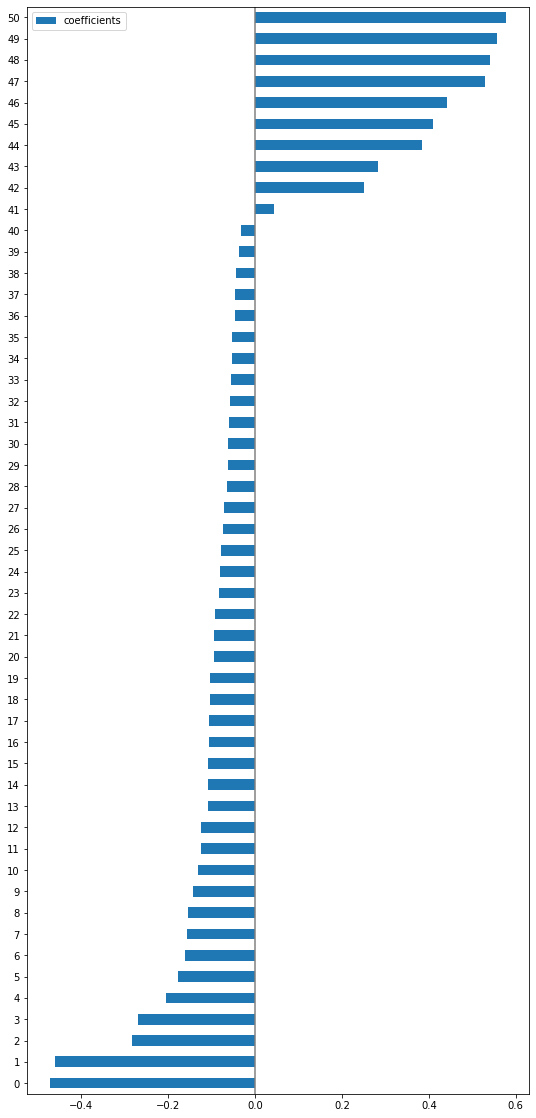

In [115]:
# set up coefficients of lr model
feature_names = lr_lrti_abs_incdt.feature_names_in_
coef = np.squeeze(lr_lrti_abs_incdt.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_lrti/coef_lr_lrti_abs_incdt.csv', index=False)

# obtain intercept
interc = lr_lrti_abs_incdt.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_lrti/intercept_lrti_abs_incdt.txt', interc, delimiter=',')

# plot coefficients
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for incident hospital admission \n related to lrti with antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/coef_lr_lrti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

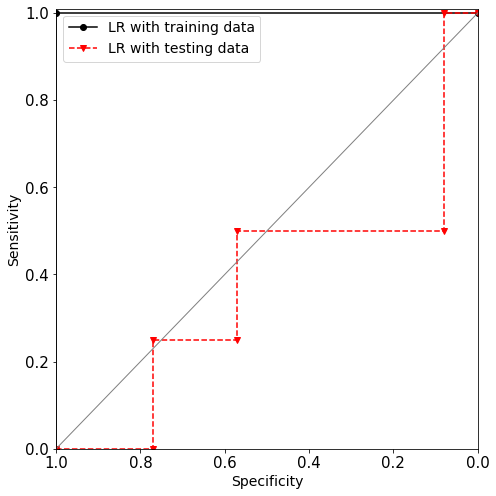

In [110]:
r_fpr1, r_tpr1, _ = roc_curve(data_lrti_abs_incdt_lr_y_train, pred_proba_lrti_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_lrti_abs_incdt_lr_y_test, pred_proba_lrti_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to incident \nlrti with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/roc_lr_lrti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [113]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_lrti_abs_incdt_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_lrti_abs_incdt_train.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_lrti_abs_incdt_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_lrti_abs_incdt_test.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

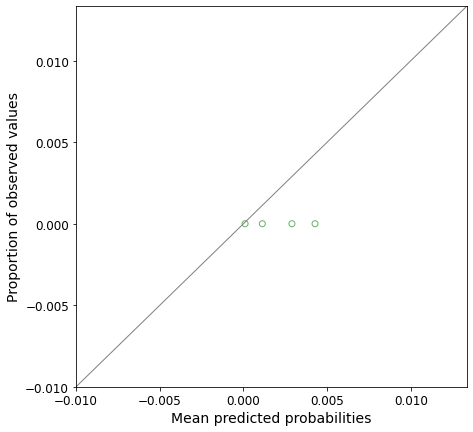

In [114]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_lr_lrti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

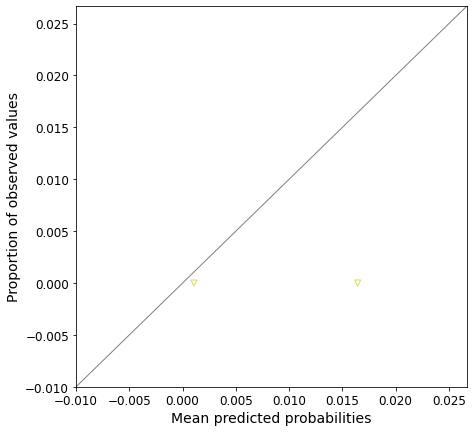

In [115]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_lr_lrti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# fig, ax1 = pyplot.subplots(figsize=(7, 7))
# fop1, mpv1, = calibration_curve(data_lrti_abs_incdt_lr_y_train, pred_proba_lrti_abs_incdt_train[:,1], n_bins=10, strategy='quantile')
# fop2, mpv2, = calibration_curve(data_lrti_abs_incdt_lr_y_test, pred_proba_lrti_abs_incdt_test[:,1], n_bins=10, strategy='quantile')
# pyplot.plot(mpv1, fop1, marker='.', markersize=12, markevery=0.1, linestyle='-')
# pyplot.plot(mpv2, fop2, marker='.', markersize=12, markevery=0.1, linestyle='-')
# pyplot.xlabel('Predicted probabilities', fontsize=14)
# pyplot.ylabel('Observed values', fontsize=14)
# pyplot.xticks(fontsize=12)
# pyplot.yticks(fontsize=12, rotation=0)
# pyplot.xlim(0, 0.2)
# pyplot.ylim(0, 0.2)
# pyplot.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
# pyplot.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
# pyplot.savefig('../output/hospitalisation_prediction_lrti/calib_lr_lrti_abs_incdt.jpg', bbox_inches='tight')
# pyplot.show()

In [116]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_lrti_abs_incdt_lr_y_train, pred_proba_lrti_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_lrti_abs_incdt_lr_y_test, pred_proba_lrti_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_lrti_abs_incdt_lr_y_train, pred_proba_lrti_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_lrti_abs_incdt_lr_y_test, pred_proba_lrti_abs_incdt_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_lrti/lr_lrti_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident lrti with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident lrti with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident lrti with antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident lrti with antibiotics = %.4f' % (brier2)])

### 6-1-3- Prevalent hospital admission related to lrti with no antibiotics

In [62]:
# encoding categorical data for LR
data = data_lrti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_lrti_no_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_lrti_no_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_lrti_no_abs_prevl_enc = data[['antibacterial_brit', 'gp_count']].join(data_lrti_no_abs_prevl_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_lrti_admitted', 'duration_lrti_admitted'

data_lrti_no_abs_prevl_enc.head()

In [61]:
#randomly splitting data into training (%75) and testing (%25)
data_lrti_no_abs_prevl_lr_X_train, data_lrti_no_abs_prevl_lr_X_test, data_lrti_no_abs_prevl_lr_y_train, data_lrti_no_abs_prevl_lr_y_test = train_test_split(data_lrti_no_abs_prevl_enc, data_lrti_no_abs_prevl.event_lrti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_lrti_no_abs_prevl_lr_X for training: {data_lrti_no_abs_prevl_lr_X_train.shape}')
print(f'shape of data_lrti_no_abs_prevl_lr_X for testing: {data_lrti_no_abs_prevl_lr_X_test.shape}')
print(f'shape of data_lrti_no_abs_prevl_lr_y for training: {data_lrti_no_abs_prevl_lr_y_train.shape}')
print(f'shape of data_lrti_no_abs_prevl_lr_y for testing: {data_lrti_no_abs_prevl_lr_y_test.shape}')

In [122]:
#build LR model
lr_lrti_no_abs_prevl = LogisticRegression().fit(data_lrti_no_abs_prevl_lr_X_train, data_lrti_no_abs_prevl_lr_y_train)

#prediction of hsopital admission related to lrti of training data using lr
pred_proba_lrti_no_abs_prevl_train = lr_lrti_no_abs_prevl.predict_proba(data_lrti_no_abs_prevl_lr_X_train)
# pred_proba_lrti_no_abs_prevl_train

#calculate score of lr_lrti_no_abs_prevl with training data
lr_lrti_no_abs_prevl_training_score = lr_lrti_no_abs_prevl.score(data_lrti_no_abs_prevl_lr_X_train, data_lrti_no_abs_prevl_lr_y_train)
print(f'score of lr_lrti_no_abs_prevl with training data: {lr_lrti_no_abs_prevl_training_score}')

#prediction of hsopital admission related to lrti of testing data using lr
pred_proba_lrti_no_abs_prevl_test = lr_lrti_no_abs_prevl.predict_proba(data_lrti_no_abs_prevl_lr_X_test)
# pred_proba_lrti_no_abs_prevl_test

#calculate score of lr_lrti_no_abs_prevl with testing data
lr_lrti_no_abs_prevl_testing_score = lr_lrti_no_abs_prevl.score(data_lrti_no_abs_prevl_lr_X_test, data_lrti_no_abs_prevl_lr_y_test)
print(f'score of lr_lrti_no_abs_prevl with testing data: {lr_lrti_no_abs_prevl_testing_score}')

In [123]:
# set up coefficients of lr model
feature_names = lr_lrti_no_abs_prevl.feature_names_in_
coef = np.squeeze(lr_lrti_no_abs_prevl.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_lrti/coef_lr_lrti_no_abs_prevl.csv', index=False)

# obtain intercept
interc = lr_lrti_no_abs_prevl.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_lrti/intercept_lrti_no_abs_prevl.txt', interc, delimiter=',')

# plot coefficients
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for prevalent hospital admission \n related to lrti with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/coef_lr_lrti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()


In [124]:
r_fpr1, r_tpr1, _ = roc_curve(data_lrti_no_abs_prevl_lr_y_train, pred_proba_lrti_no_abs_prevl_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_lrti_no_abs_prevl_lr_y_test, pred_proba_lrti_no_abs_prevl_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to prevalent \nlrti with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/roc_lr_lrti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_lrti_no_abs_prevl_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_lrti_no_abs_prevl_train.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin

In [ ]:
#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_lrti_no_abs_prevl_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_lrti_no_abs_prevl_test.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_lr_lrti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_lrti/calibration_lr_lrti_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [221]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_lrti_no_abs_prevl_lr_y_train, pred_proba_lrti_no_abs_prevl_train[:,1])
r_auc2 = roc_auc_score(data_lrti_no_abs_prevl_lr_y_test, pred_proba_lrti_no_abs_prevl_test[:,1])
brier1 = brier_score_loss(data_lrti_no_abs_prevl_lr_y_train, pred_proba_lrti_no_abs_prevl_train[:,1])
brier2 = brier_score_loss(data_lrti_no_abs_prevl_lr_y_test, pred_proba_lrti_no_abs_prevl_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_lrti/lr_lrti_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to prevalent lrti with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to prevalent lrti with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to prevalent lrti with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to prevalent lrti with no antibiotics = %.4f' % (brier2)])

### 6-1-4- Prevalent hospital admission related to lrti with antibiotics

In [ ]:
# encoding categorical data for LR
data = data_lrti_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_lrti_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_lrti_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_lrti_abs_prevl_enc = data[['antibacterial_brit', 'gp_count']].join(data_lrti_abs_prevl_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_lrti_admitted', 'duration_lrti_admitted'

data_lrti_abs_prevl_enc.head()

In [ ]:
#randomly splitting data into training (%75) and testing (%25)
data_lrti_abs_prevl_lr_X_train, data_lrti_abs_prevl_lr_X_test, data_lrti_abs_prevl_lr_y_train, data_lrti_abs_prevl_lr_y_test = train_test_split(data_lrti_abs_prevl_enc, data_lrti_abs_prevl.event_lrti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_lrti_abs_prevl_lr_X for training: {data_lrti_abs_prevl_lr_X_train.shape}')
print(f'shape of data_lrti_abs_prevl_lr_X for testing: {data_lrti_abs_prevl_lr_X_test.shape}')
print(f'shape of data_lrti_abs_prevl_lr_y for training: {data_lrti_abs_prevl_lr_y_train.shape}')
print(f'shape of data_lrti_abs_prevl_lr_y for testing: {data_lrti_abs_prevl_lr_y_test.shape}')

In [ ]:
#build LR model
lr_lrti_abs_prevl = LogisticRegression().fit(data_lrti_abs_prevl_lr_X_train, data_lrti_abs_prevl_lr_y_train)

#prediction of hsopital admission related to lrti of training data using lr
pred_proba_lrti_abs_prevl_train = lr_lrti_abs_prevl.predict_proba(data_lrti_abs_prevl_lr_X_train)
# pred_proba_lrti_abs_prevl_train

#calculate score of lr_lrti_abs_prevl with training data
lr_lrti_abs_prevl_training_score = lr_lrti_abs_prevl.score(data_lrti_abs_prevl_lr_X_train, data_lrti_abs_prevl_lr_y_train)
print(f'score of lr_lrti_abs_prevl with training data: {lr_lrti_abs_prevl_training_score}')

#prediction of hsopital admission related to lrti of testing data using lr
pred_proba_lrti_abs_prevl_test = lr_lrti_abs_prevl.predict_proba(data_lrti_abs_prevl_lr_X_test)
# pred_proba_lrti_abs_prevl_test

#calculate score of lr_lrti_abs_prevl with testing data
lr_lrti_abs_prevl_testing_score = lr_lrti_abs_prevl.score(data_lrti_abs_prevl_lr_X_test, data_lrti_abs_prevl_lr_y_test)
print(f'score of lr_lrti_abs_prevl with testing data: {lr_lrti_abs_prevl_testing_score}')

In [ ]:
# set up coefficients of lr model
feature_names = lr_lrti_abs_prevl.feature_names_in_
coef = np.squeeze(lr_lrti_abs_prevl.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_lrti/coef_lr_lrti_abs_prevl.csv', index=False)

# obtain intercept
interc = lr_lrti_abs_prevl.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_lrti/intercept_lrti_abs_prevl.txt', interc, delimiter=',')

# plot coefficients
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for incident hospital admission \n related to lrti with antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/coef_lr_lrti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
r_fpr1, r_tpr1, _ = roc_curve(data_lrti_abs_prevl_lr_y_train, pred_proba_lrti_abs_prevl_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_lrti_abs_prevl_lr_y_test, pred_proba_lrti_abs_prevl_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to incident \nlrti with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/roc_lr_lrti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_lrti_abs_prevl_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_lrti_abs_prevl_train.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin

In [ ]:
#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_lrti_abs_prevl_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_lrti_abs_prevl_test.event_lrti_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_lrti_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
# fig, ax1 = plt.subplots(figsize=(7, 7))
# plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
# plt.xlabel('Mean predicted probabilities', fontsize=14)
# plt.ylabel('Proportion of observed values', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12, rotation=0)
# plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# # plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
# plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
# plt.savefig('../output/hospitalisation_prediction_lrti/calibration_lr_lrti_abs_prevl_train.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# fig, ax1 = plt.subplots(figsize=(7, 7))
# plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
# plt.xlabel('Mean predicted probabilities', fontsize=14)
# plt.ylabel('Proportion of observed values', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12, rotation=0)
# plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# # plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
# plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
# plt.savefig('../output/hospitalisation_prediction_lrti/calibration_lr_lrti_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_lrti_abs_prevl_lr_y_train, pred_proba_lrti_abs_prevl_train[:,1])
r_auc2 = roc_auc_score(data_lrti_abs_prevl_lr_y_test, pred_proba_lrti_abs_prevl_test[:,1])
brier1 = brier_score_loss(data_lrti_abs_prevl_lr_y_train, pred_proba_lrti_abs_prevl_train[:,1])
brier2 = brier_score_loss(data_lrti_abs_prevl_lr_y_test, pred_proba_lrti_abs_prevl_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_lrti/lr_lrti_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to prevalent lrti with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to prevalent lrti with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to prevalent lrti with antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to prevalent lrti with antibiotics = %.4f' % (brier2)])